In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from pathlib import Path
import re
import seaborn as sns

In [2]:
ROOT = Path.cwd().resolve()

DATA = (ROOT / "data").resolve()

PROV_SVC_DATA = (DATA / "prov_svc").resolve()

PROV_DATA = (DATA / "prov").resolve()

# Reading the Data in Using Pandas (Later Skipped / Commented Out)

# Provider Service Data

In [3]:
# prov_svc_2021 = pd.read_csv(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D21_Prov_Svc.csv")

In [4]:
# prov_svc_2021["Year"] = 2021

In [5]:
# prov_svc_2021.info()

In [6]:
# prov_svc_2022 = pd.read_csv(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D22_Prov_Svc.csv")

In [7]:
# prov_svc_2022["Year"] = 2022

In [8]:
# prov_svc_2022.info()

In [9]:
# prov_svc_2023 = pd.read_csv(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D23_Prov_Svc.csv")

In [10]:
# prov_svc_2023["Year"] = 2023

In [11]:
# prov_svc_2023.info()

In [12]:
# prov_svc_all = pd.concat([prov_svc_2021, prov_svc_2022, prov_svc_2023], axis= 0).reset_index(drop=True)

In [13]:
# prov_svc_all.columns

In [14]:
# prov_svc_all.info()

In [15]:
# prov_svc_all.info()

# Provider Data

In [16]:
# prov_2021 = pd.read_csv(PROV_DATA / "MUP_PHY_R25_P07_V20_D21_Prov.csv")

In [17]:
# prov_2021["Year"] = 2021

In [18]:
# [c for c in prov_2021.columns if "Cancer" in c]

In [19]:
# [c for c in prov_2021.columns if "Bene_CC_PH" in c]

In [20]:
# prov_2021.info()

In [21]:
# prov_2022 = pd.read_csv(PROV_DATA / "MUP_PHY_R25_P07_V20_D22_Prov.csv")

In [22]:
# prov_2022["Year"] = 2022

In [23]:
# [c for c in prov_2022.columns if "Cancer" in c]

In [24]:
# [c for c in prov_2022.columns if "Bene_CC_PH" in c]

In [25]:
# prov_2022.info()

In [26]:
# prov_2023 = pd.read_csv(PROV_DATA / "MUP_PHY_R25_P05_V20_D23_Prov.csv")

In [27]:
# prov_2023["Year"] = 2023

In [28]:
# [c for c in prov_2023.columns if "Cancer" in c]

In [29]:
# [c for c in prov_2023.columns if "Bene_CC_PH" in c]

In [30]:
# prov_2023.info()

In [31]:
# prov_all = pd.concat([prov_2021, prov_2022, prov_2023], axis=0).reset_index(drop=True)

In [32]:
# prov_all.columns

In [33]:
# [c for c in prov_all.columns if "Cancer" in c]

In [34]:
# prov_all.info()

In [35]:
# prov_svc_all.head(10)

In [36]:
# prov_svc_all["Rndrng_Prvdr_Ent_Cd"].value_counts()

In [37]:
# onco_prvdr_type = [s for s in prov_svc_all["Rndrng_Prvdr_Type"].value_counts().index.to_list() if "onco" in s.lower()]
# onco_prvdr_type

In [38]:
# counts_df = prov_svc_all["Rndrng_Prvdr_Type"].value_counts().reset_index().rename(columns={"count": "Count"})

# onco_counts = counts_df[counts_df["Rndrng_Prvdr_Type"].isin(onco_prvdr_type)]

# onco_counts

In [39]:
# prov_svc_all_cdI_typeOnco = prov_svc_all[(prov_svc_all["Rndrng_Prvdr_Ent_Cd"]=="I") & prov_svc_all["Rndrng_Prvdr_Type"].isin(onco_prvdr_type)].reset_index()

In [40]:
# prov_svc_all_cdI_typeOnco.info()

In [41]:
# prov_svc_all_cdI_typeOnco["Rndrng_Prvdr_Type"].value_counts()

Note:

Above steps were too memory-intensive, so I switched to DuckDB altogether for loading and inspecting the each individual dataset. 

Above, I only read in Provider Service and Provider Datasets. 

Using DuckDB, I will create a database that creates views for Provider Service, Provider, RCBS Taxonomy, and NPPES datasets. I'll sanity checks and quality control to ensure the the intended data is loaded correctly, the views are filtered for target analysis, appropriate views are joined and the final metadata is saved as a table, a Pandas dataframe and a parquet file. 

# SWITCH TO DUCKDB FOR EFFICIENCY (USE THE FOR THE REST OF THE NOTEBOOK)

In [42]:
con = duckdb.connect(database=DATA / "medicare.duckdb")

# ----------------------------
# Step 1: Provider-service union (3 years)
# ----------------------------

con.execute(
    f"""
CREATE OR REPLACE VIEW prov_svc_all AS
SELECT *, 2021 AS Year
FROM read_csv_auto('{(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D21_Prov_Svc.csv").as_posix()}')
UNION ALL
SELECT *, 2022 AS Year 
FROM read_csv_auto('{(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D22_Prov_Svc.csv").as_posix()}')
UNION ALL
SELECT *, 2023 As Year
FROM read_csv_auto('{(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D23_Prov_Svc.csv").as_posix()}');
"""
)

Visit [Medicare Physician & Other Practitioners - by Provider and Service Data Dictionary](https://data.cms.gov/resources/medicare-physician-other-practitioners-by-provider-and-service-data-dictionary).

In [43]:
# Oncology provider types: contains "onco"

con.execute("""
CREATE OR REPLACE VIEW prov_svc_onco AS
SELECT *
FROM prov_svc_all
WHERE Rndrng_Prvdr_Ent_Cd = 'I'
  AND Rndrng_Prvdr_Type IN (
    'Hematology-Oncology',
    'Medical Oncology',
    'Radiation Oncology',
    'Gynecological Oncology',
    'Surgical Oncology'
  );
""")



In [44]:
con.execute("""
CREATE OR REPLACE VIEW prov_svc_onco_core AS
SELECT *,
  CASE
    WHEN Rndrng_Prvdr_Type IN ('Hematology-Oncology', 'Medical Oncology', 'Radiation Oncology')
      THEN 1 ELSE 0
  END AS is_core_scope
FROM prov_svc_onco;
""")

In [45]:
con.sql(
    """
SELECT Rndrng_Prvdr_Type, is_core_scope, COUNT(*) AS n
FROM prov_svc_onco_core
GROUP BY 1,2
ORDER BY n DESC;
"""
)

┌────────────────────────┬───────────────┬────────┐
│   Rndrng_Prvdr_Type    │ is_core_scope │   n    │
│        varchar         │     int32     │ int64  │
├────────────────────────┼───────────────┼────────┤
│ Hematology-Oncology    │             1 │ 463136 │
│ Radiation Oncology     │             1 │ 237530 │
│ Medical Oncology       │             1 │ 155537 │
│ Gynecological Oncology │             0 │  22439 │
│ Surgical Oncology      │             0 │  20382 │
└────────────────────────┴───────────────┴────────┘

In [46]:
con.execute(
    f"""
CREATE OR REPLACE VIEW prov_all AS
SELECT *, 2021 AS Year 
FROM read_csv_auto('{(PROV_DATA / "MUP_PHY_R25_P07_V20_D21_Prov.csv").as_posix()}')
UNION ALL
SELECT *, 2022 AS Year
FROM read_csv_auto('{(PROV_DATA / "MUP_PHY_R25_P07_V20_D22_Prov.csv").as_posix()}')
UNION ALL 
SELECT *, 2023 AS Year
FROM read_csv_auto('{(PROV_DATA / "MUP_PHY_R25_P05_V20_D23_Prov.csv").as_posix()}');
"""
)

Visit: [Medicare Physician & Other Practitioners - by Provider Data Dictionary](https://data.cms.gov/resources/medicare-physician-other-practitioners-by-provider-data-dictionary)

In [47]:
con.execute(
    """
CREATE OR REPLACE VIEW prov_svc_onco_core_prov_all AS
SELECT
  ps.*,
  p.* EXCLUDE (Rndrng_NPI, Year)
FROM prov_svc_onco_core AS ps
LEFT JOIN prov_all AS p
  ON ps.Rndrng_NPI = p.Rndrng_NPI
 AND ps.Year = p.Year;
""")

Let's confirm we didn’t accidentally create duplicate provider rows in `prov_all`

In [48]:
con.sql(
    """
SELECT Year, COUNT(*) AS n_rows, COUNT(DISTINCT Rndrng_NPI) AS n_npi
FROM prov_all
GROUP BY 1
ORDER BY 1;
"""
)

┌───────┬─────────┬─────────┐
│ Year  │ n_rows  │  n_npi  │
│ int32 │  int64  │  int64  │
├───────┼─────────┼─────────┤
│  2021 │ 1198754 │ 1198754 │
│  2022 │ 1230293 │ 1230293 │
│  2023 │ 1259343 │ 1259343 │
└───────┴─────────┴─────────┘

Let's check match rate after the left join

In [49]:
con.sql(
    """
SELECT COUNT(*) AS n_rows,
       AVG(CASE WHEN Tot_Benes IS NULL THEN 1 ELSE 0 END) AS pct_missing_provider_summary
FROM prov_svc_onco_core_prov_all
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬──────────────────────────────┐
│ n_rows │ pct_missing_provider_summary │
│ int64  │            double            │
├────────┼──────────────────────────────┤
│ 899024 │                          0.0 │
└────────┴──────────────────────────────┘

In [50]:
RBCS_DATA = (DATA / "rbcs").resolve()

In [51]:
con.execute(
    f"""
CREATE OR REPLACE VIEW rbcs AS
SELECT *
FROM read_csv_auto('{(RBCS_DATA / "RBCS_Taxonomy_RY2025.csv").as_posix()}');
""")

Visit: [Restructured Berenson-Eggers Type of Service (BETOS) Classification System (RBCS) Data Dictionary](https://data.cms.gov/sites/default/files/2022-05/RBCS%20Mapping%20Data%20Dictionary.pdf)

In [52]:
con.execute(
    """
CREATE OR REPLACE VIEW prov_svc_onco_core_prov_all_rbcs AS
SELECT p.*, r.* EXCLUDE(HCPCS_Cd)
FROM prov_svc_onco_core_prov_all AS p
LEFT JOIN rbcs AS r
  ON p.HCPCS_Cd = r.HCPCS_Cd;
""")

Let's check whether the join is matching codes as expected

In [53]:
con.sql(
    """
SELECT COUNT(*) AS n_rows,
AVG(CASE WHEN RBCS_Id IS NULL THEN 1 ELSE 0 END) AS pct_missing_rbcs
FROM prov_svc_onco_core_prov_all_rbcs;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬──────────────────┐
│ n_rows │ pct_missing_rbcs │
│ int64  │      double      │
├────────┼──────────────────┤
│ 962304 │              0.0 │
└────────┴──────────────────┘

In [54]:
NPPES_DATA = (DATA / "nppes").resolve()

In [55]:
con.execute(
    f"""
CREATE OR REPLACE VIEW nppes_raw AS 
SELECT * 
FROM read_csv_auto('{(NPPES_DATA / "npidata_pfile_20050523-20260111.csv").as_posix()}');
"""
)

In [56]:
con.sql(
    """
SELECT *
FROM nppes_raw
LIMIT 4
"""
)

┌────────────┬──────────────────┬─────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬─────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬───────────────────┬──────────────────────┬──────────────────────┬──────────────

In [57]:
con.sql("DESCRIBE SELECT * FROM nppes_raw").df().head(60)

,column_name,column_type,null,key,default,extra
0,NPI,BIGINT,YES,None,None,None
1,Entity Type Code,BIGINT,YES,None,None,None
2,Replacement NPI,BIGINT,YES,None,None,None
3,Employer Identification Number (EIN),VARCHAR,YES,None,None,None
4,Provider Organization Name (Legal Business Name),VARCHAR,YES,None,None,None
5,Provider Last Name (Legal Name),VARCHAR,YES,None,None,None
6,Provider First Name,VARCHAR,YES,None,None,None
7,Provider Middle Name,VARCHAR,YES,None,None,None
8,Provider Name Prefix Text,VARCHAR,YES,None,None,None
9,Provider Name Suffix Text,VARCHAR,YES,None,None,None


Let's create a slim NPPES view

In [58]:
con.execute(
    """
CREATE OR REPLACE VIEW nppes AS 
SELECT NPI,
       "Entity Type Code" AS entity_type_code,
       "Provider Enumeration Date" AS enumeration_date
FROM nppes_raw
WHERE Entity_Type_Code = 1;
"""
)

In [59]:
con.sql(
    """
SELECT *
FROM nppes
LIMIT 4
"""
)

┌────────────┬──────────────────┬──────────────────┐
│    NPI     │ entity_type_code │ enumeration_date │
│   int64    │      int64       │       date       │
├────────────┼──────────────────┼──────────────────┤
│ 1679576722 │                1 │ 2005-05-23       │
│ 1588667638 │                1 │ 2005-05-23       │
│ 1215930367 │                1 │ 2005-05-23       │
│ 1932102084 │                1 │ 2005-05-23       │
└────────────┴──────────────────┴──────────────────┘

In [60]:
con.sql(
    """
SELECT * 
FROM nppes
"""
).df().columns

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['NPI', 'entity_type_code', 'enumeration_date'], dtype='object')

#### Let's do a quick sanity check. 

In [61]:
con.sql(
    """
SELECT
  COUNT(*) AS n_rows,
  MIN(enumeration_date) AS min_date,
  MAX(enumeration_date) AS max_date
FROM nppes;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬────────────┬────────────┐
│ n_rows  │  min_date  │  max_date  │
│  int64  │    date    │    date    │
├─────────┼────────────┼────────────┤
│ 7105591 │ 2005-05-23 │ 2026-01-10 │
└─────────┴────────────┴────────────┘

#### Let's left join the `prov_svc_onco_core_prov_all_rbcs` table with the `nppes` table on `Rndrng_NPI` on the left side and `NPI` on the right side.

In [62]:
con.execute(
    """
CREATE OR REPLACE VIEW prov_svc_onco_core_prov_all_rbcs_nppes AS
SELECT
    t.*,
    n.enumeration_date,
    CASE
        WHEN n.enumeration_date IS NULL
        THEN NULL
        ELSE (t.Year - EXTRACT(year FROM n.enumeration_date))::INTEGER
    END AS years_since_enumeration
FROM prov_svc_onco_core_prov_all_rbcs AS t
LEFT JOIN nppes AS n
    ON CAST(t.Rndrng_NPI AS BIGINT) = n.NPI;
"""
)

In [63]:
con.sql(
    """
SELECT
  COUNT(*) AS n_rows,
  AVG(CASE WHEN enumeration_date IS NULL THEN 1 ELSE 0 END) AS pct_missing_enumeration_date,
  MIN(years_since_enumeration) AS min_years,
  MAX(years_since_enumeration) AS max_years
FROM prov_svc_onco_core_prov_all_rbcs_nppes;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬──────────────────────────────┬───────────┬───────────┐
│ n_rows │ pct_missing_enumeration_date │ min_years │ max_years │
│ int64  │            double            │   int32   │   int32   │
├────────┼──────────────────────────────┼───────────┼───────────┤
│ 962304 │         0.004274117118914605 │         0 │        18 │
└────────┴──────────────────────────────┴───────────┴───────────┘

In [64]:
con.execute(
    """
CREATE OR REPLACE TABLE prov_svc_onco_core_prov_all_rbcs_nppes_tbl AS
SELECT * FROM prov_svc_onco_core_prov_all_rbcs_nppes;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [65]:
OUT_PARQUET = (DATA / "prov_svc_onco_core_prov_all_rbcs_nppes.parquet").as_posix()

con.execute(
    f"""
COPY prov_svc_onco_core_prov_all_rbcs_nppes_tbl
TO '{OUT_PARQUET}'
(FORMAT PARQUET);
"""
)

#### Reading the master dataset in using Pandas:

In [66]:
import pandas as pd
df = pd.read_parquet(DATA / "prov_svc_onco_core_prov_all_rbcs_nppes.parquet")
df.shape
df.head()

,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,Rndrng_Prvdr_State_Abrvtn,...,HCPCS_Cd_Add_Dt,HCPCS_Cd_End_Dt,RBCS_Latest_Assignment,First_RBCS_Release_Year,RBCS_Analysis_Start_Dt,RBCS_Analysis_End_Dt,Alt_Assignment_Method,RBCS_Id_Ever_Reassigned,enumeration_date,years_since_enumeration
0,1013191733,Ramsdale,Erika,E,M.D.,I,601 Elmwood Ave,None,Rochester,NY,...,1992-01-01,9999-12-31,1,2020,2014-01-01,9999-12-31,0,0,2007-12-18,14.0
1,1013191790,Derose,Erin,R,M.D.,I,Beth Israel Deaconess Medical Center,"330 Brookline Ave, East #2, Rm 215",Boston,MA,...,1992-01-01,9999-12-31,1,2020,2014-01-01,9999-12-31,0,0,2007-12-18,14.0
2,1013191790,Derose,Erin,R,M.D.,I,Beth Israel Deaconess Medical Center,"330 Brookline Ave, East #2, Rm 215",Boston,MA,...,1992-01-01,9999-12-31,1,2020,2014-01-01,9999-12-31,0,0,2007-12-18,14.0
3,1013191790,Derose,Erin,R,M.D.,I,Beth Israel Deaconess Medical Center,"330 Brookline Ave, East #2, Rm 215",Boston,MA,...,1992-01-01,9999-12-31,1,2020,2014-01-01,9999-12-31,0,0,2007-12-18,14.0
4,1013191790,Derose,Erin,R,M.D.,I,Beth Israel Deaconess Medical Center,"330 Brookline Ave, East #2, Rm 215",Boston,MA,...,1992-01-01,9999-12-31,1,2020,2014-01-01,9999-12-31,0,0,2007-12-18,14.0


In [67]:
desc = con.sql(
    """
DESCRIBE 
    SELECT *
    FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl;
"""
).df()

# show all rows
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

desc

,column_name,column_type,null,key,default,extra
0,Rndrng_NPI,BIGINT,YES,None,None,None
1,Rndrng_Prvdr_Last_Org_Name,VARCHAR,YES,None,None,None
2,Rndrng_Prvdr_First_Name,VARCHAR,YES,None,None,None
3,Rndrng_Prvdr_MI,VARCHAR,YES,None,None,None
4,Rndrng_Prvdr_Crdntls,VARCHAR,YES,None,None,None
5,Rndrng_Prvdr_Ent_Cd,VARCHAR,YES,None,None,None
6,Rndrng_Prvdr_St1,VARCHAR,YES,None,None,None
7,Rndrng_Prvdr_St2,VARCHAR,YES,None,None,None
8,Rndrng_Prvdr_City,VARCHAR,YES,None,None,None
9,Rndrng_Prvdr_State_Abrvtn,VARCHAR,YES,None,None,None


#### Table 1: provider_year_features (small, stable, best for EDA + clustering)

In [68]:
con.execute("""
CREATE OR REPLACE TABLE provider_year_features AS
SELECT
  Rndrng_NPI,
  Year,

  -- provider identity (should be constant within NPI-Year)
  MAX(Rndrng_Prvdr_Type) AS provider_type,
  MAX(is_core_scope) AS is_core_scope,
  MAX(Rndrng_Prvdr_State_Abrvtn) AS state,
  MAX(Rndrng_Prvdr_Zip5) AS zip5,
  MAX(Rndrng_Prvdr_RUCA) AS ruca,
  MAX(Rndrng_Prvdr_RUCA_Desc) AS ruca_desc,

  -- provider-year totals (from provider summary)
  MAX(Tot_HCPCS_Cds) AS tot_hcpcs_cds,
  MAX(Tot_Benes_1) AS tot_benes,
  MAX(Tot_Srvcs_1) AS tot_srvcs,
  MAX(Tot_Sbmtd_Chrg) AS tot_sbmtd_chrg,
  MAX(Tot_Mdcr_Alowd_Amt) AS tot_mdcr_allowed_amt,
  MAX(Tot_Mdcr_Pymt_Amt) AS tot_mdcr_payment_amt,
  MAX(Tot_Mdcr_Stdzd_Amt) AS tot_mdcr_stdzd_amt,

  -- derived unit costs at provider-year level
  MAX(Tot_Mdcr_Stdzd_Amt) / NULLIF(MAX(Tot_Srvcs_1), 0) AS stdzd_amt_per_service,
  MAX(Tot_Mdcr_Pymt_Amt) / NULLIF(MAX(Tot_Srvcs_1), 0) AS payment_amt_per_service,
  MAX(Tot_Mdcr_Alowd_Amt) / NULLIF(MAX(Tot_Srvcs_1), 0) AS allowed_amt_per_service,

  -- drug vs medical totals (optional but useful)
  MAX(Drug_Tot_Srvcs) AS drug_tot_srvcs,
  MAX(Drug_Mdcr_Stdzd_Amt) AS drug_mdcr_stdzd_amt,
  MAX(Med_Tot_Srvcs) AS med_tot_srvcs,
  MAX(Med_Mdcr_Stdzd_Amt) AS med_mdcr_stdzd_amt,

  -- case-mix proxies
  MAX(Bene_Avg_Risk_Scre) AS bene_avg_risk_score,

  -- demographics counts (optional)
  MAX(Bene_Avg_Age) AS bene_avg_age,
  MAX(Bene_Feml_Cnt) AS bene_female_cnt,
  MAX(Bene_Male_Cnt) AS bene_male_cnt,
  MAX(Bene_Dual_Cnt) AS bene_dual_cnt,
  MAX(Bene_Ndual_Cnt) AS bene_nondual_cnt,

  -- chronic condition percentages (keep as features, even if they are BIGINT)
  MAX(Bene_CC_PH_Cancer6_V2_Pct) AS pct_cancer6,
  MAX(Bene_CC_PH_Diabetes_V2_Pct) AS pct_diabetes,
  MAX(Bene_CC_PH_CKD_V2_Pct) AS pct_ckd,
  MAX(Bene_CC_PH_COPD_V2_Pct) AS pct_copd,
  MAX(Bene_CC_PH_Hypertension_V2_Pct) AS pct_htn,

  -- experience proxy (from NPPES join)
  MAX(years_since_enumeration) AS years_since_enumeration

FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
GROUP BY 1, 2;
""")

In [69]:
OUT = (DATA / "provider_year_features.parquet").as_posix()
con.execute(f"COPY provider_year_features TO '{OUT}' (FORMAT PARQUET);")

#### Table 2: provider_service_features (modeling table for regression benchmark)

In [70]:
con.execute("""
CREATE OR REPLACE TABLE provider_service_features AS
SELECT
  Rndrng_NPI,
  Year,
  MAX(Rndrng_Prvdr_Type) AS provider_type,
  MAX(is_core_scope) AS is_core_scope,

  -- service grouping
  RBCS_FamNumb,
  MAX(RBCS_Family_Desc) AS rbcs_family_desc,
  MAX(RBCS_Cat) AS rbcs_cat,
  MAX(RBCS_Cat_Subcat) AS rbcs_cat_subcat,

  -- context
  Place_Of_Srvc,
  MAX(Rndrng_Prvdr_State_Abrvtn) AS state,
  MAX(Rndrng_Prvdr_Zip5) AS zip5,
  MAX(Rndrng_Prvdr_RUCA) AS ruca,

  -- volume and exposure
  SUM(Tot_Srvcs) AS services,
  SUM(Tot_Benes) AS benes,
  SUM(Tot_Bene_Day_Srvcs) AS bene_day_services,

  -- weighted average “price” targets (per service)
  SUM(Avg_Mdcr_Stdzd_Amt * Tot_Srvcs) / NULLIF(SUM(Tot_Srvcs), 0) AS stdzd_amt_per_service,
  SUM(Avg_Mdcr_Alowd_Amt * Tot_Srvcs) / NULLIF(SUM(Tot_Srvcs), 0) AS allowed_amt_per_service,
  SUM(Avg_Mdcr_Pymt_Amt * Tot_Srvcs) / NULLIF(SUM(Tot_Srvcs), 0) AS payment_amt_per_service,
  SUM(Avg_Sbmtd_Chrg * Tot_Srvcs) / NULLIF(SUM(Tot_Srvcs), 0) AS submitted_charge_per_service,

  -- provider-level features (repeated across service rows, so take MAX)
  MAX(Bene_Avg_Risk_Scre) AS bene_avg_risk_score,
  MAX(years_since_enumeration) AS years_since_enumeration,

  -- a few case-mix features (add more later if you want)
  MAX(Bene_CC_PH_Cancer6_V2_Pct) AS pct_cancer6,
  MAX(Bene_CC_PH_Diabetes_V2_Pct) AS pct_diabetes,
  MAX(Bene_CC_PH_CKD_V2_Pct) AS pct_ckd,
  MAX(Bene_CC_PH_COPD_V2_Pct) AS pct_copd,
  MAX(Bene_CC_PH_Hypertension_V2_Pct) AS pct_htn

FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
WHERE RBCS_FamNumb IS NOT NULL  -- keep only rows mapped to RBCS
GROUP BY 1,2,5,9;
""")

In [71]:
OUT = (DATA / "provider_service_features.parquet").as_posix()
con.execute(f"COPY provider_service_features TO '{OUT}' (FORMAT PARQUET);")

## QC or sanity checks on the newly created dataframes

### QC A. Row counts and uniqueness at the intended grain

1) provider_year_features should be unique on (Rndrng_NPI, Year)

In [72]:
con.sql("""
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT (Rndrng_NPI, Year)) AS n_unique_keys,
  COUNT(*) - COUNT(DISTINCT (Rndrng_NPI, Year)) AS n_duplicate_keys
FROM provider_year_features;
""").df()

,n_rows,n_unique_keys,n_duplicate_keys
0,56804,56804,0


2) provider_service_features should be unique on (Rndrng_NPI, Year, RBCS_FamNumb, Place_Of_Srvc)

In [73]:
con.sql("""
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT (Rndrng_NPI, Year, RBCS_FamNumb, Place_Of_Srvc)) AS n_unique_keys,
  COUNT(*) - COUNT(DISTINCT (Rndrng_NPI, Year, RBCS_FamNumb, Place_Of_Srvc)) AS n_duplicate_keys
FROM provider_service_features;
""").df()

,n_rows,n_unique_keys,n_duplicate_keys
0,329571,329571,0


### QC B. Missingness and “must-have” fields

3) Provider-year: check missing core fields

In [74]:
con.sql("""
SELECT
  AVG(CASE WHEN tot_benes IS NULL THEN 1 ELSE 0 END) AS pct_missing_tot_benes,
  AVG(CASE WHEN tot_srvcs IS NULL THEN 1 ELSE 0 END) AS pct_missing_tot_srvcs,
  AVG(CASE WHEN tot_mdcr_stdzd_amt IS NULL THEN 1 ELSE 0 END) AS pct_missing_tot_stdzd_amt,
  AVG(CASE WHEN bene_avg_risk_score IS NULL THEN 1 ELSE 0 END) AS pct_missing_risk,
  AVG(CASE WHEN years_since_enumeration IS NULL THEN 1 ELSE 0 END) AS pct_missing_years_since_enum
FROM provider_year_features;
""").df()

,pct_missing_tot_benes,pct_missing_tot_srvcs,pct_missing_tot_stdzd_amt,pct_missing_risk,pct_missing_years_since_enum
0,0.0,0.0,0.0,0.0,0.005563


4) Provider-service: check mapping and targets

In [75]:
con.sql("""
SELECT
  AVG(CASE WHEN RBCS_FamNumb IS NULL THEN 1 ELSE 0 END) AS pct_missing_family,
  AVG(CASE WHEN services IS NULL OR services = 0 THEN 1 ELSE 0 END) AS pct_zero_services,
  AVG(CASE WHEN stdzd_amt_per_service IS NULL THEN 1 ELSE 0 END) AS pct_missing_stdzd,
  AVG(CASE WHEN allowed_amt_per_service IS NULL THEN 1 ELSE 0 END) AS pct_missing_allowed,
  AVG(CASE WHEN payment_amt_per_service IS NULL THEN 1 ELSE 0 END) AS pct_missing_payment
FROM provider_service_features;
""").df()

,pct_missing_family,pct_zero_services,pct_missing_stdzd,pct_missing_allowed,pct_missing_payment
0,0.0,0.0,0.0,0.0,0.0


### QC C. Validate the weighted-average math behaves

5) Spot-check that the “per service” amounts are in sane ranges

Run percentiles to detect garbage (like negative, huge, or all zeros):

In [76]:
con.sql("""
SELECT
  quantile_cont(stdzd_amt_per_service, 0.01) AS p01_stdzd,
  quantile_cont(stdzd_amt_per_service, 0.50) AS p50_stdzd,
  quantile_cont(stdzd_amt_per_service, 0.99) AS p99_stdzd,
  MIN(stdzd_amt_per_service) AS min_stdzd,
  MAX(stdzd_amt_per_service) AS max_stdzd
FROM provider_service_features
WHERE services >= 11;
""").df()

,p01_stdzd,p50_stdzd,p99_stdzd,min_stdzd,max_stdzd
0,0.118456,69.715955,592.728642,0.0,17228.780462


In [77]:
con.sql("""
SELECT
  quantile_cont(allowed_amt_per_service, 0.01) AS p01_stdzd,
  quantile_cont(allowed_amt_per_service, 0.50) AS p50_stdzd,
  quantile_cont(allowed_amt_per_service, 0.99) AS p99_stdzd,
  MIN(allowed_amt_per_service) AS min_stdzd,
  MAX(allowed_amt_per_service) AS max_stdzd
FROM provider_service_features
WHERE services >= 11;
""").df()

,p01_stdzd,p50_stdzd,p99_stdzd,min_stdzd,max_stdzd
0,0.150202,93.082234,763.992314,0.0,21978.744923


In [78]:
con.sql("""
SELECT
  quantile_cont(payment_amt_per_service, 0.01) AS p01_stdzd,
  quantile_cont(payment_amt_per_service, 0.50) AS p50_stdzd,
  quantile_cont(payment_amt_per_service, 0.99) AS p99_stdzd,
  MIN(payment_amt_per_service) AS min_stdzd,
  MAX(payment_amt_per_service) AS max_stdzd
FROM provider_service_features
WHERE services >= 11;
""").df()

,p01_stdzd,p50_stdzd,p99_stdzd,min_stdzd,max_stdzd
0,0.11763,70.829815,609.241805,0.0,17580.387538


Check how often the target is exactly zero (because the p01 is 0.0 across all three targets).


In [79]:
con.sql("""
SELECT
  AVG(CASE WHEN stdzd_amt_per_service = 0 THEN 1 ELSE 0 END) AS pct_zero_stdzd,
  AVG(CASE WHEN allowed_amt_per_service = 0 THEN 1 ELSE 0 END) AS pct_zero_allowed,
  AVG(CASE WHEN payment_amt_per_service = 0 THEN 1 ELSE 0 END) AS pct_zero_payment
FROM provider_service_features;
""").df()

,pct_zero_stdzd,pct_zero_allowed,pct_zero_payment
0,0.000003,0.000006,0.000009


### QC D. Reconciliation checks (to ensure you didn’t accidentally double-count)

6) Provider-year totals vs sum of provider-service “reconstructed totals”

In [80]:
con.sql("""
WITH svc_recon AS (
  SELECT
    Rndrng_NPI,
    Year,
    SUM(stdzd_amt_per_service * services) AS recon_stdzd_amt,
    SUM(services) AS recon_services
  FROM provider_service_features
  GROUP BY 1,2
),
joined AS (
  SELECT
    y.Rndrng_NPI,
    y.Year,
    y.tot_mdcr_stdzd_amt,
    y.tot_srvcs,
    s.recon_stdzd_amt,
    s.recon_services,
    (s.recon_stdzd_amt / NULLIF(y.tot_mdcr_stdzd_amt, 0)) AS ratio_stdzd_amt,
    (s.recon_services / NULLIF(y.tot_srvcs, 0)) AS ratio_services
  FROM provider_year_features y
  LEFT JOIN svc_recon s
    ON y.Rndrng_NPI = s.Rndrng_NPI
   AND y.Year = s.Year
)
SELECT
  COUNT(*) AS n,
  AVG(CASE WHEN ratio_stdzd_amt BETWEEN 0.5 AND 1.5 THEN 1 ELSE 0 END) AS pct_ratio_stdzd_in_0_5_to_1_5,
  quantile_cont(ratio_stdzd_amt, 0.50) AS median_ratio_stdzd,
  quantile_cont(ratio_services, 0.50) AS median_ratio_services
FROM joined
WHERE tot_mdcr_stdzd_amt > 0 AND tot_srvcs > 0;
""").df()

,n,pct_ratio_stdzd_in_0_5_to_1_5,median_ratio_stdzd,median_ratio_services
0,56804,0.750158,0.868156,0.891288


### QC E. Quick sanity distributions by year and specialty

In [81]:
con.sql("""
SELECT
  Year,
  provider_type,
  COUNT(*) AS n_providers,
  AVG(stdzd_amt_per_service) AS avg_stdzd_per_service,
  AVG(bene_avg_risk_score) AS avg_risk
FROM provider_year_features
GROUP BY 1,2
ORDER BY 1, n_providers DESC;
""").df()

,Year,provider_type,n_providers,avg_stdzd_per_service,avg_risk
0,2021,Hematology-Oncology,8473,57.715393,2.084437
1,2021,Radiation Oncology,4700,98.463051,1.675871
2,2021,Medical Oncology,3510,64.890229,2.104725
3,2021,Surgical Oncology,999,188.571247,1.476846
4,2021,Gynecological Oncology,967,128.739813,1.535519
5,2022,Hematology-Oncology,8600,58.817534,2.037216
6,2022,Radiation Oncology,4753,98.196350,1.627348
7,2022,Medical Oncology,3554,65.147048,2.071836
8,2022,Surgical Oncology,1046,185.938028,1.455400
9,2022,Gynecological Oncology,976,129.606148,1.504749


## Creating the EDA dataset

In [82]:
OUT = (DATA / "eda_dataset.parquet").as_posix()

con.execute("""
CREATE OR REPLACE TABLE eda_dataset AS
SELECT
  -- keys
  ps.Rndrng_NPI,
  ps.Year,
  ps.RBCS_FamNumb,
  ps.Place_Of_Srvc,

  -- labels for readability (not for modeling)
  ps.rbcs_family_desc,
  ps.rbcs_cat,
  ps.rbcs_cat_subcat,

  -- provider context
  ps.provider_type,
  ps.is_core_scope,
  ps.state,
  ps.zip5,
  ps.ruca,

  -- derived RUCA bucket (simplifies plots and modeling later)
  CASE
    WHEN ps.ruca IS NULL THEN 'Unknown'
    WHEN ps.ruca <= 3 THEN 'Urban'
    WHEN ps.ruca <= 6 THEN 'Suburban'
    ELSE 'Rural'
  END AS ruca_bucket,

  -- exposure
  ps.services,
  ps.benes,
  ps.bene_day_services,

  -- observed “price” outcomes (per service)
  ps.stdzd_amt_per_service,
  ps.allowed_amt_per_service,
  ps.payment_amt_per_service,
  ps.submitted_charge_per_service,

  -- observed totals (useful for spend concentration plots)
  ps.stdzd_amt_per_service * ps.services AS stdzd_spend,
  ps.allowed_amt_per_service * ps.services AS allowed_spend,
  ps.payment_amt_per_service * ps.services AS payment_spend,
  ps.submitted_charge_per_service * ps.services AS submitted_spend,

  -- log transforms for EDA and later modeling
  ln(1 + ps.stdzd_amt_per_service) AS log_stdzd_amt_per_service,
  ln(1 + ps.services) AS log_services,
  ln(1 + ps.benes) AS log_benes,

  -- case-mix and experience
  ps.bene_avg_risk_score,
  ps.years_since_enumeration,

  -- condition percentage features (keep both raw and scaled)
  ps.pct_cancer6,
  ps.pct_diabetes,
  ps.pct_ckd,
  ps.pct_copd,
  ps.pct_htn,

  -- many CMS “Pct” fields are 0-100 like percent values.
  -- We also provide 0-1 scaled versions for correlations/models.
  (CAST(ps.pct_cancer6 AS DOUBLE) / 100.0) AS p_cancer6,
  (CAST(ps.pct_diabetes AS DOUBLE) / 100.0) AS p_diabetes,
  (CAST(ps.pct_ckd AS DOUBLE) / 100.0) AS p_ckd,
  (CAST(ps.pct_copd AS DOUBLE) / 100.0) AS p_copd,
  (CAST(ps.pct_htn AS DOUBLE) / 100.0) AS p_htn,

  -- optional provider-year totals for context checks
  py.tot_benes,
  py.tot_srvcs,
  py.tot_mdcr_stdzd_amt,
  py.stdzd_amt_per_service AS provider_year_stdzd_amt_per_service

FROM provider_service_features AS ps
LEFT JOIN provider_year_features AS py
  ON ps.Rndrng_NPI = py.Rndrng_NPI
 AND ps.Year = py.Year

WHERE ps.services >= 11
  AND ps.stdzd_amt_per_service IS NOT NULL
  AND ps.stdzd_amt_per_service >= 0
;
""")

con.execute(f"COPY eda_dataset TO '{OUT}' (FORMAT PARQUET);")

## EDA 0. Setup and data load

**Code**

- Load parquet
- Print shape, dtypes
- Show the grain: confirm unique key counts

**Questions answered**

- What is the unit of analysis?
- How big is the dataset after feasibility filters?

In [83]:
eda_df = pd.read_parquet(DATA/"eda_dataset.parquet")

In [84]:
eda_df.shape

(329571, 43)

In [85]:
eda_df.dtypes

Rndrng_NPI                               int64
Year                                     int32
RBCS_FamNumb                            object
Place_Of_Srvc                           object
rbcs_family_desc                        object
rbcs_cat                                object
rbcs_cat_subcat                         object
provider_type                           object
is_core_scope                            int32
state                                   object
zip5                                    object
ruca                                   float64
ruca_bucket                             object
services                               float64
benes                                  float64
bene_day_services                      float64
stdzd_amt_per_service                  float64
allowed_amt_per_service                float64
payment_amt_per_service                float64
submitted_charge_per_service           float64
stdzd_spend                            float64
allowed_spend

In [86]:
eda_df.columns

Index(['Rndrng_NPI', 'Year', 'RBCS_FamNumb', 'Place_Of_Srvc',
       'rbcs_family_desc', 'rbcs_cat', 'rbcs_cat_subcat', 'provider_type',
       'is_core_scope', 'state', 'zip5', 'ruca', 'ruca_bucket', 'services',
       'benes', 'bene_day_services', 'stdzd_amt_per_service',
       'allowed_amt_per_service', 'payment_amt_per_service',
       'submitted_charge_per_service', 'stdzd_spend', 'allowed_spend',
       'payment_spend', 'submitted_spend', 'log_stdzd_amt_per_service',
       'log_services', 'log_benes', 'bene_avg_risk_score',
       'years_since_enumeration', 'pct_cancer6', 'pct_diabetes', 'pct_ckd',
       'pct_copd', 'pct_htn', 'p_cancer6', 'p_diabetes', 'p_ckd', 'p_copd',
       'p_htn', 'tot_benes', 'tot_srvcs', 'tot_mdcr_stdzd_amt',
       'provider_year_stdzd_amt_per_service'],
      dtype='object')

In [87]:
print(type(eda_df))

<class 'pandas.core.frame.DataFrame'>


In [88]:
eda_df[["Rndrng_NPI","Year","RBCS_FamNumb","Place_Of_Srvc"]].count()

Rndrng_NPI       329571
Year             329571
RBCS_FamNumb     329571
Place_Of_Srvc    329571
dtype: int64

Checking the number of uniqe values each variables has 

In [89]:
eda_df.nunique().sort_values(ascending=False)

payment_spend                          315397
allowed_spend                          314980
payment_amt_per_service                299432
allowed_amt_per_service                296249
stdzd_spend                            286113
stdzd_amt_per_service                  274022
log_stdzd_amt_per_service              273517
submitted_charge_per_service           227797
submitted_spend                        227767
provider_year_stdzd_amt_per_service     56797
tot_mdcr_stdzd_amt                      56743
log_services                            26697
services                                26697
Rndrng_NPI                              20919
bene_avg_risk_score                     18540
tot_srvcs                               17828
bene_day_services                        6331
log_benes                                3278
benes                                    3278
zip5                                     3107
tot_benes                                1660
rbcs_family_desc                  

Let's prove what one row represents in our eda dataset by checking that the columns we claim define a row are unique.

In the EDA dataset, the grain is supposed to be:

1 row = (Rndrng_NPI, Year, RBCS_FamNumb, Place_Of_Srvc)

In [90]:
key_cols = ["Rndrng_NPI","Year","RBCS_FamNumb","Place_Of_Srvc"]

n_rows = eda_df.shape[0]
n_unique = eda_df[key_cols].drop_duplicates().shape[0]
n_dupe = n_rows - n_unique

print("n_rows:", n_rows)
print("n_unique_keys:", n_unique)
print("n_duplicate_rows:", n_dupe)

n_rows: 329571
n_unique_keys: 329571
n_duplicate_rows: 0


## EDA 1. Data quality and completeness

**Plots / tables**

1. Missingness table (percent missing per column)
2. Category sanity tables:
    - counts of `provider_type`
    - counts of `Place_Of_Srvc`
    - counts of `ruca_bucket`
    - top 20 `rbcs_family_desc` by rows

**Questions answered**

- Are there missing values that could bias modeling?
- Do we have unexpected categories or weird values?

In [91]:
miss_cnt = eda_df.isna().sum().rename("n_missing")
miss_pct = (eda_df.isna().mean()*100).rename("pct_missing")

In [92]:
miss=(
    pd.concat([miss_cnt,miss_pct],axis=1)
    .reset_index(names="column")
    .query("n_missing>0")
    .sort_values("n_missing", ascending=False))

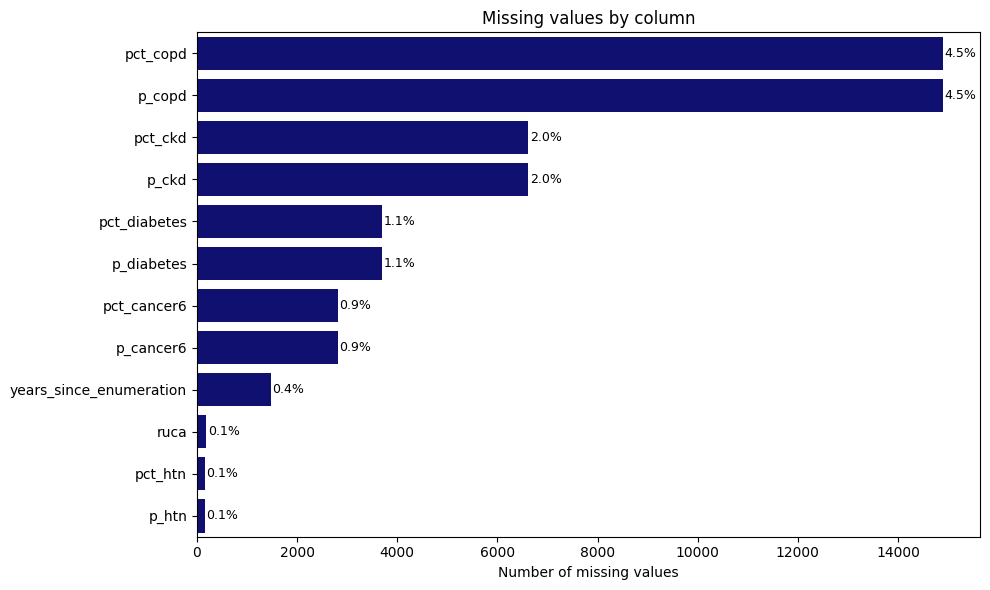

In [93]:
plt.figure(figsize=(10, max(4,0.5*len(miss))))

g = sns.barplot(data=miss, x="n_missing", y="column", orient="h", color="#000080")

max_missing = miss["n_missing"].max()

g.set(
    title="Missing values by column",
    xlabel="Number of missing values",
    ylabel=""
)

# 3) Annotate % missing
for i, (cnt, pct) in enumerate(zip(miss["n_missing"], miss["pct_missing"])):
    # Offset text slightly to the right of the bar
    g.text(cnt + (max_missing * 0.002), i, f"{pct:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.show()

In [94]:
eda_df[["provider_type","Place_Of_Srvc","ruca_bucket","rbcs_family_desc"]].nunique()

provider_type         5
Place_Of_Srvc         2
ruca_bucket           4
rbcs_family_desc    113
dtype: int64

In [95]:
eda_df["provider_type"].unique()

array(['Medical Oncology', 'Radiation Oncology', 'Hematology-Oncology',
       'Gynecological Oncology', 'Surgical Oncology'], dtype=object)

In [96]:
eda_df["Place_Of_Srvc"].unique()

array(['F', 'O'], dtype=object)

In [97]:
eda_df["ruca_bucket"].unique()

array(['Urban', 'Suburban', 'Rural', 'Unknown'], dtype=object)

In [98]:
eda_df["rbcs_family_desc"].unique()[0:20]

array(['Hospital E&M - Initial', 'Radiation Treatment Planning',
       'Office E&M - New', 'Telephone Services',
       'Conventional Radiation Treatment',
       'Erythropoiesis - Stimulating Agent', 'Chemotherapeutic Agent',
       'Office E&M - Established', 'Hospital E&M - Subsequent',
       'Chemotherapy Administration', 'No RBCS Family',
       'Intravenous Infusion, Hydration', 'Vaccine - Toxoids',
       'Injection Administration',
       'Intensity Modulated Radiation Therapy',
       'CT/CTA - Abdomen and Pelvis', 'Ultrasound - Nonspecific',
       'Hospital Discharge Management', 'PET- Oncology', 'Immunoassay'],
      dtype=object)

Important realization: `“No RBCS Family”` showing up in `rbcs_family_desc` is not automatically wrong, but it is worth verifying what it corresponds to. It might be a real label in the RBCS file, or it might indicate some mapping fallback.

Quick check: If it’s truly mapped, RBCS_FamNumb should still be present and consistent.

In [99]:
con.sql(
    """
SELECT
  rbcs_family_desc,
  COUNT(*) AS n,
  MIN(RBCS_FamNumb) AS min_fam,
  MAX(RBCS_FamNumb) AS max_fam
FROM provider_service_features
WHERE rbcs_family_desc = 'No RBCS Family'
GROUP BY 1;
"""
)

┌──────────────────┬───────┬─────────┬─────────┐
│ rbcs_family_desc │   n   │ min_fam │ max_fam │
│     varchar      │ int64 │ varchar │ varchar │
├──────────────────┼───────┼─────────┼─────────┤
│ No RBCS Family   │ 25993 │ 000     │ 000     │
└──────────────────┴───────┴─────────┴─────────┘

`"No RBCS Family"` looks like a real, intentional value in your RBCS mapping, not a join failure.

Because:

- We have **RBCS_FamNumb = ‘000’** for every one of those rows (min and max both `000`), and the description is consistently `"No RBCS Family"`.
- If this were a join miss, we would typically see `RBCS_FamNumb` as `NULL` (or missing) after the join, not a stable sentinel like `000`.
- We also previously saw `pct_missing_rbcs = 0.0`, which strongly suggests the taxonomy file contains entries for these HCPCS codes and is assigning them to a “none/other/unclassified” bucket.

So it is probably a legitimate “catch-all” category: “this HCPCS code is in the taxonomy file but not assigned to a meaningful family.” But we have to confirm this finding.

Quick checks: How big is it relative to the dataset?

In [100]:
con.sql(
    """
SELECT
  COUNT(*) AS n_all,
  SUM(CASE WHEN RBCS_FamNumb='000' THEN 1 ELSE 0 END) AS n_000,
  1.0 * SUM(CASE WHEN RBCS_FamNumb='000' THEN 1 ELSE 0 END) / COUNT(*) AS pct_000
FROM provider_service_features;
"""
)

┌────────┬────────┬─────────────────────┐
│ n_all  │ n_000  │       pct_000       │
│ int64  │ int128 │       double        │
├────────┼────────┼─────────────────────┤
│ 329571 │  25993 │ 0.07886919662227562 │
└────────┴────────┴─────────────────────┘

Quick checks: Does it have very different cost/exposure?

In [101]:
con.sql(
    """
SELECT
  CASE WHEN RBCS_FamNumb='000' THEN '000_NoFamily' ELSE 'OtherFamilies' END AS grp,
  COUNT(*) AS n_rows,
  AVG(services) AS avg_services,
  quantile_cont(log_stdzd_amt_per_service, 0.50) AS med_log_stdzd,
  quantile_cont(log_stdzd_amt_per_service, 0.95) AS p95_log_stdzd
FROM eda_df
GROUP BY 1;
"""
)

┌───────────────┬────────┬────────────────────┬────────────────────┬───────────────────┐
│      grp      │ n_rows │    avg_services    │   med_log_stdzd    │   p95_log_stdzd   │
│    varchar    │ int64  │       double       │       double       │      double       │
├───────────────┼────────┼────────────────────┼────────────────────┼───────────────────┤
│ 000_NoFamily  │  25993 │  12234.04850536683 │ 3.3826939100975957 │ 6.142579116825249 │
│ OtherFamilies │ 303578 │ 2835.7386935153404 │  4.291046929442693 │ 5.784211048322115 │
└───────────────┴────────┴────────────────────┴────────────────────┴───────────────────┘

This is exactly the kind of check that makes the story credible. Based on your results, I would treat RBCS_FamNumb = #### '000' as a real, meaningful segment and handle it explicitly.

**What these numbers are saying**

**Size**

- 000 is **7.9%** of rows (25,993 out of 329,571). That’s too big to ignore as a “quirk”, but small enough that it #### could distort things if it behaves differently.

**Exposure (services)**

- 000_NoFamily has **much higher average services** per row: ~12,234 vs ~2,836.
- That is a big structural difference. It suggests 000 rows are not “typical families”, they might be umbrella #### billing codes, very high volume codes, or catch-all codes that aggregate a lot of activity.

**Cost level (log standardized cost per service)**

- Median log cost is **lower** for 000 (3.38) vs others (4.29).
    - On the original scale, that’s roughly exp(3.38) ≈ 29 vs exp(4.29) ≈ 73 (this is approximate because you used log1p, but the conclusion holds).
- The **95th percentile is similar-ish** (6.14 vs 5.78). So the tail is not wildly different, but the center is.

So yes, I would call it meaningfully different. Even if the p95 is close, the median and the services volume difference are telling you this group is a different “kind” of row.





<br>

**Quick extra check before locking the decision**

The one thing I’d verify is whether 000 is concentrated in a specific place of service or provider type.

In [102]:
con.sql(
    """
SELECT
  Place_Of_Srvc,
  provider_type,
  COUNT(*) AS n_rows,
  AVG(services) AS avg_services,
  quantile_cont(log_stdzd_amt_per_service, 0.50) AS med_log_stdzd
FROM eda_df
WHERE RBCS_FamNumb = '000'
GROUP BY 1,2
ORDER BY n_rows DESC;
"""
)

┌───────────────┬────────────────────────┬────────┬────────────────────┬───────────────────┐
│ Place_Of_Srvc │     provider_type      │ n_rows │    avg_services    │   med_log_stdzd   │
│    varchar    │        varchar         │ int64  │       double       │      double       │
├───────────────┼────────────────────────┼────────┼────────────────────┼───────────────────┤
│ O             │ Hematology-Oncology    │  10741 │  22764.76187505819 │  1.15926928806898 │
│ O             │ Medical Oncology       │   3508 │  18156.78720068415 │  1.20481350113386 │
│ F             │ Hematology-Oncology    │   2455 │  78.64684317718941 │ 4.097672352314776 │
│ F             │ Radiation Oncology     │   2230 │  75.68161434977578 │ 4.085348198572007 │
│ O             │ Radiation Oncology     │   2070 │  2657.969082125604 │ 4.001586659483845 │
│ F             │ Surgical Oncology      │   1583 │  44.85975994946305 │ 4.715727176552735 │
│ F             │ Gynecological Oncology │   1427 │  38.54660126138753

This table makes it very clear that **RBCS_FamNumb = '000'** is not just a harmless “misc” label. It behaves like multiple different sub-populations depending on place of service and provider type.

**What these result implies**

**1) The biggest driver is Place_Of_Srvc = O for HemOnc and MedOnc**

Look at these two rows:

- **O, Hematology-Oncology:** 10,741 rows, **avg_services ~ 22,765**, **median log cost ~ 1.16**
- **O, Medical Oncology:** 3,508 rows, **avg_services ~ 18,157**, **median log cost ~ 1.20**

That median log cost is extremely low relative to the rest of your dataset. These look like very high-volume, very low standardized cost-per-service rows, which is exactly the kind of pattern you get from “special” codes, aggregation-type codes, or something that is not comparable to a standard service family.

**2) The F rows look much more “normal”**

When Place_Of_Srvc = F, the median log costs are around ~4 to 6, and avg_services are tens, not tens of thousands. Example:

- **F, HemOnc:** avg_services ~ 79, med log ~ 4.10
- **F, RadOnc:** avg_services ~ 76, med log ~ 4.09
- **F, GynOnc:** avg_services ~ 39, med log ~ 6.24 (higher)

So 000 is not one thing. It’s at least two very different things depending on place of service.

**What to do with 000 now**

Two possible strategies:

**Option A (recommended): Keep 000, but model it explicitly with interactions**

Do all of this:

1. Add a flag
- is_no_rbcs_family = 1 if RBCS_FamNumb == '000' else 0
2. Add an interaction-type feature (either explicit or via model)
- For Ridge: you can explicitly create a feature like is_no_rbcs_family * is_place_O (or just rely on one-hot plus linear interaction if you build it).
- For XGBoost: you don’t need to manually create interactions. It will split on RBCS_FamNumb == '000' and Place_Of_Srvc naturally.
3. In EDA and reporting, always show metrics stratified by:
- is_no_rbcs_family and Place_Of_Srvc

This gives you the clean story: “000 codes behave differently, especially in outpatient settings. We keep them but let the model treat them differently.”

**Option B (cleanest benchmarking narrative): Separate-track modeling**

- **Main benchmark model:** train on RBCS_FamNumb != '000' only.
- **Secondary model:** train on RBCS_FamNumb == '000' only (and maybe even split by Place_Of_Srvc inside it).

This avoids mixing apples and oranges. It also prevents those huge-volume low-cost O rows from influencing the main model’s learned relationships.

**Which option fits your goal best?**

Since we want the headline metric to be **O/E standardized cost per service** and we want the benchmarking story to be clean, here’s the best alignment:

- If the report/dashboard is meant to be “benchmark real oncology service families,” then **Option B** is the cleanest.
- If the product goal is “give every provider-year-service row an expected cost,” then **Option A** is better.



<br>

**One more tiny QC that will make the decision obvious**

Let's check whether those crazy high avg_services rows also dominate total volume. If (O, HemOnc) and (O, MedOnc) are most of the services too, then separating 000 is usually the safest.

In [103]:
con.sql(
    """
SELECT
  Place_Of_Srvc,
  provider_type,
  SUM(services) AS total_services,
  COUNT(*) AS n_rows,
  1.0 * SUM(services) / (SELECT SUM(services) FROM eda_df WHERE RBCS_FamNumb='000') AS pct_of_000_services
FROM eda_df
WHERE RBCS_FamNumb='000'
GROUP BY 1,2
ORDER BY total_services DESC;
"""
)

┌───────────────┬────────────────────────┬────────────────────┬────────┬────────────────────────┐
│ Place_Of_Srvc │     provider_type      │   total_services   │ n_rows │  pct_of_000_services   │
│    varchar    │        varchar         │       double       │ int64  │         double         │
├───────────────┼────────────────────────┼────────────────────┼────────┼────────────────────────┤
│ O             │ Hematology-Oncology    │ 244516307.29999998 │  10741 │     0.7689201174109065 │
│ O             │ Medical Oncology       │         63694009.5 │   3508 │    0.20029586494213916 │
│ O             │ Radiation Oncology     │          5501996.0 │   2070 │   0.017301894736712876 │
│ O             │ Gynecological Oncology │          3629235.0 │    677 │   0.011412702216576339 │
│ F             │ Hematology-Oncology    │           193078.0 │   2455 │  0.0006071642422086546 │
│ F             │ Radiation Oncology     │           168770.0 │   2230 │   0.000530723899965582 │
│ F             │ Me

This confirms it very strongly.

**What this table says in plain English**

For the “No RBCS Family” bucket (RBCS_FamNumb = '000'):

- **Outpatient HemOnc (O, Hematology-Oncology)** accounts for **~76.9%** of *all* services in the 000 bucket.
- **Outpatient MedOnc (O, Medical Oncology)** accounts for **~20.0%**.
- Together, those two rows account for **~97%** of all 000 services.

Everything else is tiny by comparison.

So **RBCS_FamNumb='000'** is not just 7.9% of rows. It is a bucket whose *service volume* is overwhelmingly dominated by a very specific pattern (Outpatient + HemOnc/MedOnc). That means if you keep 000 in the main model without special handling, it can easily distort training, calibration, and the O/E story.

**Best recommendation**

Use **Option B (separate-track modeling)** as the default.

**Why Option B is the cleanest for your stated goal**

narrative usually assumes “we’re comparing like-with-like service families.” The 000 bucket is not behaving like a normal service family. It’s acting like a special aggregation or fallback code bucket with huge volume and very different cost behavior.

So:

1. **Main benchmark model (the one you show by default)**
- Train and score on **RBCS_FamNumb != '000'** only.
- This becomes your primary O/E story.
2. **Secondary model (optional add-on)**
- Train a separate model for **RBCS_FamNumb = '000'*, and honestly this could be restricted to just:
- (Place_Of_Srvc='O' AND provider_type IN ('Hematology-Oncology','Medical Oncology'))
- because that’s basically the whole 000 volume anyway.
- Or we can still include all provider types, but the key is keeping it separate from the main benchmark.

**What to do in the dataset**

Keep 000 rows in your data, but tag them and split the pipeline:

- model_track = 'main' if RBCS_FamNumb != '000'
- model_track = 'no_family' if RBCS_FamNumb = '000'

Then you build:

- model_dataset_main.parquet
- model_dataset_no_family.parquet (optional, can come later)



<br>

**One more quick QC that’s worth doing**

Check whether 000 is also concentrated in **specific HCPCS codes** (often a sign it’s a special code pattern):

If we see a small number of HCPCS codes dominating, that further supports “special bucket” behavior.

In [104]:
con.sql(
    """
SELECT
  p.HCPCS_Cd,
  MAX(p.HCPCS_Desc) AS hcpcs_desc,
  COUNT(*) AS n_rows,
  SUM(p.Tot_Srvcs) AS total_services
FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl p
WHERE p.RBCS_FamNumb = '000'
GROUP BY 1
ORDER BY total_services DESC
LIMIT 20;
"""
)

┌──────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────┬───────────────────┐
│ HCPCS_Cd │                                                                                                                            hcpcs_desc                                                                                                                            │ n_rows │  total_services   │
│ varchar  │                                                                                                                             varchar                                                                                                                              │ int64  │      double       │
├──────────┼─────────────────────────────────────────────────────────────────────────────────────

It seems like most of the descriptions are injections. We should confirm this by running a regex to show what percentage of all **RBCS_FamNumb = '000'** are described as "injections" at any context of specific drug.

Fast check: “Injection” share by rows and by services

If pct_services_injection is very high (for example > 0.7), then the “000 bucket” is essentially “drug units/injections” in your data.



<br>

Slightly broader keyword net

Some injection-related codes might not literally contain the word “injection” (for example contrast materials). We can create a broader “drug or injectable” bucket:

This will tell us whether “injection” alone explains most of the services, or if it’s “injection + contrast + unclassified drug” etc.

In [105]:
con.sql(
    """
WITH base AS (
  SELECT
    CASE
      WHEN lower(HCPCS_Desc) LIKE '%injection%' THEN 1
      ELSE 0
    END AS is_injection,
    Tot_Srvcs
  FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
  WHERE RBCS_FamNumb = '000'
)
SELECT
  COUNT(*) AS n_rows,
  SUM(is_injection) AS n_injection_rows,
  1.0 * SUM(is_injection) / COUNT(*) AS pct_rows_injection,

  SUM(Tot_Srvcs) AS total_services,
  SUM(CASE WHEN is_injection = 1 THEN Tot_Srvcs ELSE 0 END) AS injection_services,
  1.0 * SUM(CASE WHEN is_injection = 1 THEN Tot_Srvcs ELSE 0 END) / NULLIF(SUM(Tot_Srvcs), 0) AS pct_services_injection
FROM base;
"""
)

┌────────┬──────────────────┬────────────────────┬────────────────┬────────────────────┬────────────────────────┐
│ n_rows │ n_injection_rows │ pct_rows_injection │ total_services │ injection_services │ pct_services_injection │
│ int64  │      int128      │       double       │     double     │       double       │         double         │
├────────┼──────────────────┼────────────────────┼────────────────┼────────────────────┼────────────────────────┤
│ 144455 │            77115 │  0.533834065972102 │    317999622.8 │        290406955.0 │     0.9132305014797018 │
└────────┴──────────────────┴────────────────────┴────────────────┴────────────────────┴────────────────────────┘

Bonus: Let's use `HCPCS_Drug_Ind` in our `prov_svc_onco_core_prov_all_rbcs_nppes_tbl`

Our big table appears to have `HCPCS_Drug_Ind`. If it’s reliable, it’s cleaner than regex:

**What this means for our modeling decision**

If you confirm that 000 is mostly drug-unit injection codes:

- It strengthens the case to **exclude RBCS_FamNumb='000' from the main service-family benchmark model** (your Option B main track).
- Then you can treat 000 as a **secondary “drug units” track** later, with its own modeling logic and careful interpretation.

In [106]:
con.sql(
    """
WITH base AS (
  SELECT
    lower(HCPCS_Desc) AS d,
    Tot_Srvcs
  FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
  WHERE RBCS_FamNumb = '000'
),
tagged AS (
  SELECT
    CASE
      WHEN d LIKE '%injection%' THEN 'injection'
      WHEN d LIKE '%contrast%' THEN 'contrast'
      WHEN d LIKE '%unclassified drug%' OR d LIKE '%unclassified drugs%' THEN 'unclassified_drug'
      WHEN d LIKE '%chemotherap%' THEN 'chemo'
      WHEN d LIKE '%imaging%' OR d LIKE '%gadol%' OR d LIKE '%radiology%' THEN 'imaging_related'
      ELSE 'other'
    END AS bucket,
    Tot_Srvcs
  FROM base
)
SELECT
  bucket,
  COUNT(*) AS n_rows,
  SUM(Tot_Srvcs) AS total_services,
  1.0 * SUM(Tot_Srvcs) / (SELECT SUM(Tot_Srvcs) FROM tagged) AS pct_services
FROM tagged
GROUP BY 1
ORDER BY total_services DESC;
"""
)

┌───────────────────┬────────┬───────────────────┬────────────────────────┐
│      bucket       │ n_rows │  total_services   │      pct_services      │
│      varchar      │ int64  │      double       │         double         │
├───────────────────┼────────┼───────────────────┼────────────────────────┤
│ injection         │  77115 │       290406955.0 │     0.9132305014797019 │
│ contrast          │   2841 │        21484037.0 │    0.06755994491701643 │
│ other             │  55557 │         5201991.5 │   0.016358483240314085 │
│ unclassified_drug │   4502 │ 713898.2999999999 │  0.0022449658704437937 │
│ chemo             │   2553 │          149348.0 │  0.0004696483558218863 │
│ imaging_related   │   1887 │           43393.0 │ 0.00013645613670205904 │
└───────────────────┴────────┴───────────────────┴────────────────────────┘

In [107]:
con.sql(
    """
SELECT
  HCPCS_Drug_Ind,
  COUNT(*) AS n_rows,
  SUM(Tot_Srvcs) AS total_services,
  1.0 * SUM(Tot_Srvcs) / (SELECT SUM(Tot_Srvcs)
                          FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
                          WHERE RBCS_FamNumb='000') AS pct_services
FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
WHERE RBCS_FamNumb='000'
GROUP BY 1
ORDER BY total_services DESC;
"""
)

┌────────────────┬────────┬────────────────┬─────────────────────┐
│ HCPCS_Drug_Ind │ n_rows │ total_services │    pct_services     │
│    varchar     │ int64  │     double     │       double        │
├────────────────┼────────┼────────────────┼─────────────────────┤
│ Y              │  88703 │    313115904.5 │  0.9846423770663667 │
│ N              │  55752 │      4883718.3 │ 0.01535762293363324 │
└────────────────┴────────┴────────────────┴─────────────────────┘

It seems that most of the RBCS_FamNumb='000'  are actually related to injections.

These three checks line up perfectly, and they give us a very defensible conclusion.
What your results mean
1) “Injection” dominates by services (the important lens)
Only 53.4% of rows contain the word “injection”.
But those rows account for 91.3% of total services in the 000 bucket.
So the 000 bucket is not “half injections” in the sense that matters for modeling. It’s overwhelmingly injection volume.
2) Your broader keyword tagging confirms the same story
Injection: 91.3% of services
Contrast: 6.8% of services
Everything else combined is small.
This is very consistent with “drug units and related items” rather than standard “service families.”
3) The drug indicator seals it
HCPCS_Drug_Ind = 'Y' is 98.5% of services in 000.
That is huge. It means RBCS_FamNumb='000' is basically a drug-related bucket in your extracted oncology universe.
What we should do (clear recommendation)
Use the split-track approach:
Main benchmarking model (your portfolio headline)
Train and score ONLY on rows where:
RBCS_FamNumb IS NOT NULL
RBCS_FamNumb <> '000'
This is your clean “apples-to-apples service-family benchmarking engine.”
Secondary “drug unit” track (optional add-on)
Keep RBCS_FamNumb='000' rows separate.
If you include it later, frame it honestly as “drug unit and related codes (injections, contrast).”
It can be its own model or a descriptive module. It does not need to be part of the core benchmark story.
This aligns with your goal: make the primary narrative clean and interview-safe for Garner/Oscar.
How to describe this decision in your write-up
You can say something like:
“RBCS family ‘000’ represents non-standard family assignments in RBCS. In our oncology subset, it is overwhelmingly drug-related volume: 98.5% of services have HCPCS_Drug_Ind='Y', and 91.3% of services are codes whose description includes ‘injection’. Because drug unit billing behaves differently from service-family costs, we exclude RBCS ‘000’ from the main service-family benchmark model and treat it as a separate track.”
That sounds thoughtful, not like data cleaning hand-waving.

## EDA 3. Outcome distributions and log justification

**Plots**

1. Histogram: `stdzd_amt_per_service` (raw)
2. Histogram: `log_stdzd_amt_per_service`
3. Box plot: `stdzd_amt_per_service` by `Place_Of_Srvc` (overall)
4. Percentiles table for standardized, allowed, payment, submitted:
    - p01, p50, p90, p95, p99, max

**Questions answered**

- How skewed are costs?
- Does log transform stabilize the distribution?
- Are there extreme outliers that will dominate training if we do not log?

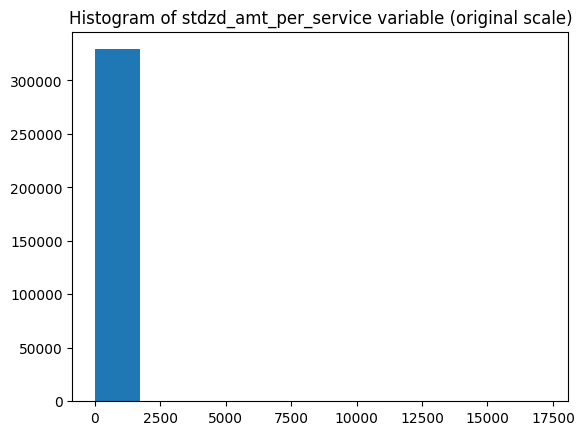

In [108]:
plt.hist(eda_df["stdzd_amt_per_service"])
plt.title("Histogram of stdzd_amt_per_service variable (original scale)")
plt.show()

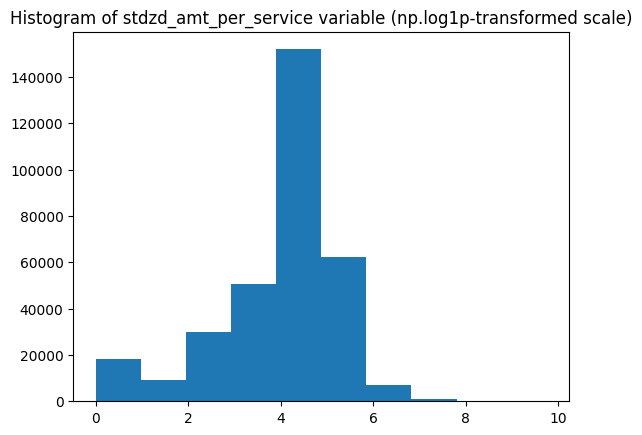

In [109]:
plt.hist(np.log1p(eda_df["stdzd_amt_per_service"]))
plt.title("Histogram of stdzd_amt_per_service variable (np.log1p-transformed scale)")
plt.show()

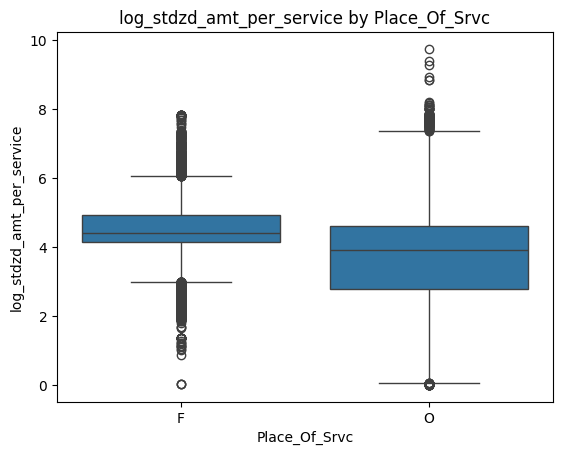

In [110]:
g = sns.boxplot(data=eda_df,
                x = "Place_Of_Srvc",
                y="log_stdzd_amt_per_service")
g.set_title("log_stdzd_amt_per_service by Place_Of_Srvc")
plt.show()

In [111]:
cols = ["stdzd_amt_per_service", "allowed_amt_per_service", "payment_amt_per_service"]

percentiles = eda_df[cols].quantile([0.01, 0.5, 0.9, 0.95, 0.99])

max_vals = eda_df[cols].max().to_frame().T
max_vals.index = [1.0]

result = pd.concat([percentiles, max_vals])
print(result)



      stdzd_amt_per_service  allowed_amt_per_service  payment_amt_per_service
0.01               0.118456                 0.150202                 0.117630
0.50              69.715955                93.082234                70.829815
0.90             157.020000               209.680000               163.903333
0.95             327.002895               400.830229               318.351347
0.99             592.728642               763.992314               609.241805
1.00           17228.780462             21978.744923             17580.387538


## EDA 3. Exposure, reliability, and threshold selection

**Plots**

1. Histogram: services
2. CDF plot: cumulative share of rows by services
3. Scatter: `services` vs `stdzd_amt_per_service` (use log x-axis)
4. Optional: binned variance plot
    - bin services into ranges and show cost variance per bin

**Questions answered**

- How much of the dataset is low-volume and noisy?
- Is services >= 11 reasonable for training?
- What threshold should we use later for “flagging” outliers (like 50+)?

Histogram of services: The distribution of exposure (how many services went into each row’s per-service cost).


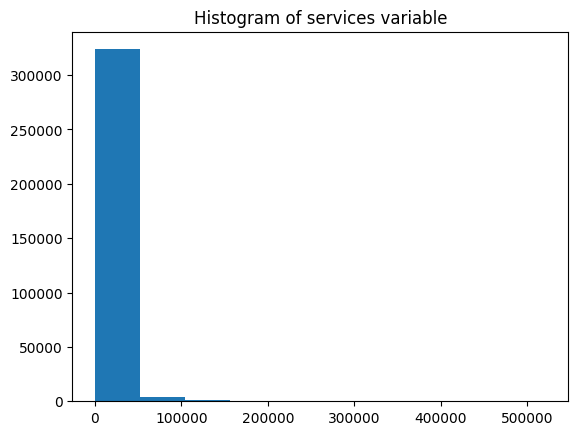

In [112]:
plt.hist(eda_df["services"])
plt.title("Histogram of services variable")
plt.show()

The histogram is xtremely right-skewed. Most rows have relatively low services, and a small number of rows have massive service counts (up to ~500k). That is normal in claims-like utilization data.

Low-service rows have noisier “per service” averages. High-service rows have very stable averages.

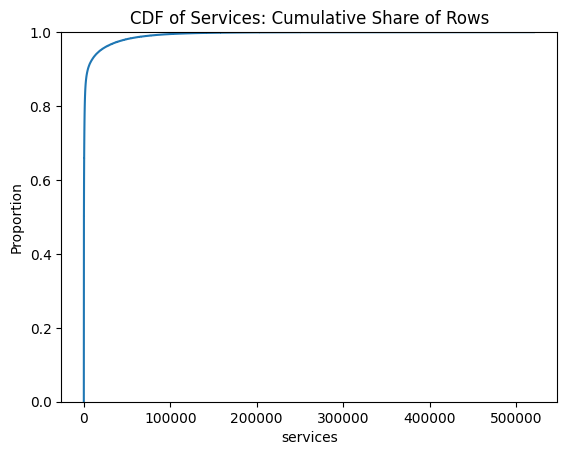

In [113]:
sns.ecdfplot(data = eda_df, x="services")
plt.title("CDF of Services: Cumulative Share of Rows")
plt.show()

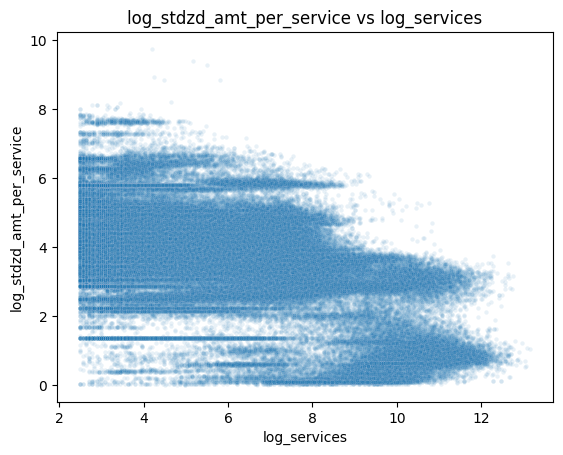

In [114]:
eda_df["log_services"] = np.log1p(eda_df["services"])

g = sns.scatterplot(data=eda_df, x = "log_services", y="log_stdzd_amt_per_service", alpha=0.1, s=10)
g.set_title("log_stdzd_amt_per_service vs log_services")
plt.show()

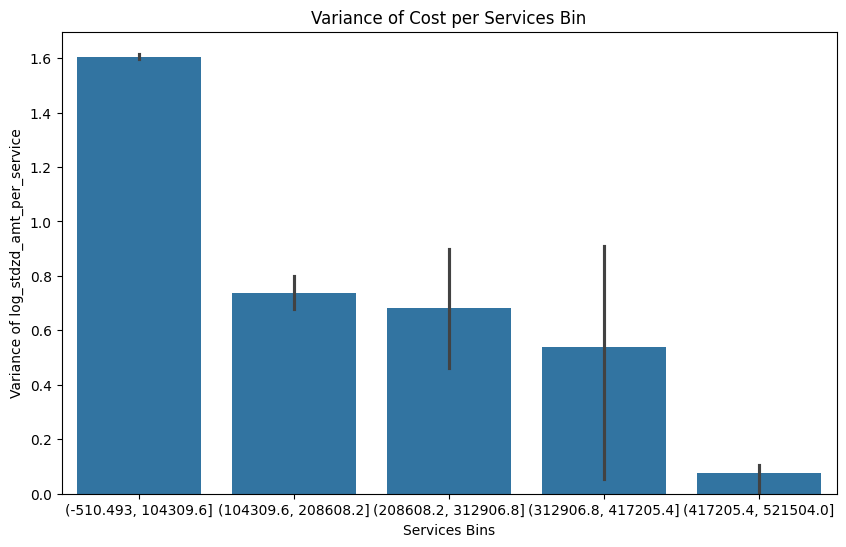

In [115]:
# 1. Create a binned version of 'services' (e.g., 5 equal-width bins)
eda_df['services_bins'] = pd.cut(eda_df['services'], bins=5)

# 2. Plot variance per bin
plt.figure(figsize=(10, 6))
sns.barplot(data=eda_df, x='services_bins', y='log_stdzd_amt_per_service', estimator=np.var)

plt.title('Variance of Cost per Services Bin')
plt.ylabel('Variance of log_stdzd_amt_per_service')
plt.xlabel('Services Bins')
plt.show()

In [116]:
# Define custom edges: 0 to 11, 11 to 25, 25 to 50, 50 to 100, and 100+
custom_bins = [0, 11, 25, 50, 100, np.inf]
custom_labels = ['0-11', '12-25', '26-50', '51-100', '100+']

# Create the binned column
eda_df['services_custom'] = pd.cut(
    eda_df['services'], 
    bins=custom_bins, 
    labels=custom_labels, 
    include_lowest=True
)

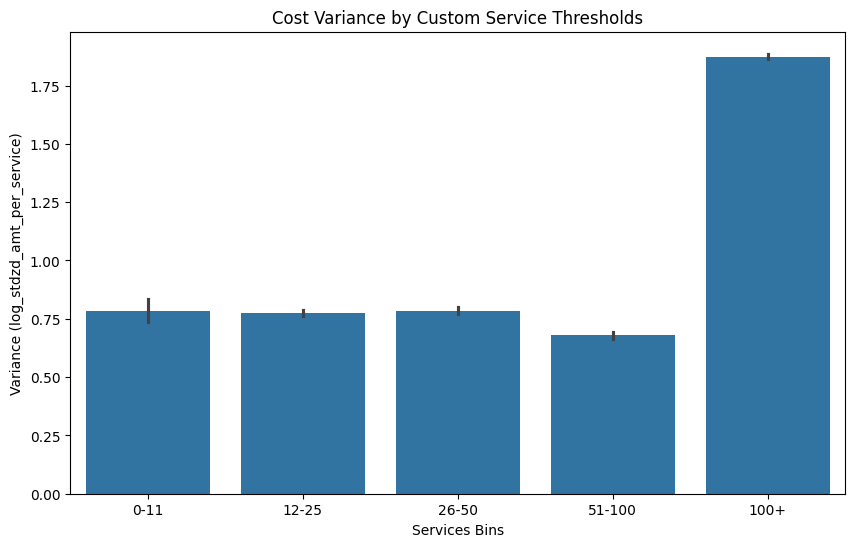

In [117]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=eda_df, 
    x='services_custom', 
    y='log_stdzd_amt_per_service', 
    estimator=np.var
)

plt.title('Cost Variance by Custom Service Thresholds')
plt.ylabel('Variance (log_stdzd_amt_per_service)')
plt.xlabel('Services Bins')
plt.show()


**Adding counts per bin**

We need to know if 100+ has a small number of rows (unstable estimate) or tons (real pattern).

In [118]:
eda_df.groupby("services_custom").agg(
    n_rows=("log_stdzd_amt_per_service","size"),
    var_y=("log_stdzd_amt_per_service", np.var),
    mean_y=("log_stdzd_amt_per_service","mean"),
    p95=("log_stdzd_amt_per_service", lambda s: np.quantile(s, 0.95))
)

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_78543/2312683007.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df.groupby("services_custom").agg(
/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_78543/2312683007.py:1: FutureWarning: The provided callable <function var at 0x10d856c00> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  eda_df.groupby("services_custom").agg(


,n_rows,var_y,mean_y,p95
services_custom,,,,
0-11,4299,0.785006,4.651056,6.000313
12-25,48431,0.774682,4.570140,5.807632
26-50,48115,0.784619,4.577514,5.807632
51-100,46713,0.678864,4.472975,5.801616
100+,182013,1.874238,3.508058,5.042196


**Split 100+ into sub-bins**

Keep your early bins, but break 100+ into a few more. For example:

- 101–250
- 251–1,000
- 1,001–10,000
- 10,000+

If the variance spike is really coming from, say, the “10k+” group, that is an important story.

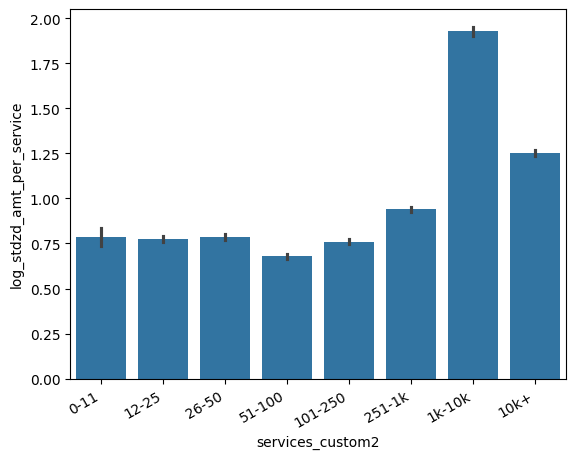

In [119]:
bins2 = [0, 11, 25, 50, 100, 250, 1000, 10000, np.inf]
labels2 = ["0-11","12-25","26-50","51-100","101-250","251-1k","1k-10k","10k+"]

eda_df["services_custom2"] = pd.cut(eda_df["services"], bins=bins2, labels=labels2, include_lowest=True)

sns.barplot(data=eda_df, x="services_custom2", y="log_stdzd_amt_per_service", estimator=np.var)
plt.xticks(rotation=30, ha="right")
plt.show()

**1) The “100+” bin is not “more reliable”. It’s a different regime.**

Look at these side by side:

- **51–100:** var ≈ **0.679**, IQR ≈ **0.780**, mean ≈ **4.47**, p95 ≈ **5.80**
- **100+:** var ≈ **1.874**, IQR ≈ **1.571**, mean ≈ **3.51**, p95 ≈ **5.04**

So 100+ is:

- **much more spread out** (variance and IQR both jump a lot),
- with a **lower mean** and **lower p95** than the smaller bins.

That means the huge variance is not just a few outliers. It’s telling us that 100+ rows are a heterogeneous mix (different families, different billing patterns, different settings), which is exactly what the sub-bin plot is showing.

**2) The split confirms the variance spike is concentrated in a middle-high range**

From the plot:

- 0–11 through 51–100 are all in the same ballpark (stable-ish).
- **101–250 and 251–1k** start drifting up a bit.
- **1k–10k** is the giant spike (the main problem).
- **10k+** drops again (still higher than low bins, but much lower than 1k–10k).

That is a classic “mixture” story: the 1k–10k segment likely contains specific high-volume drug administration patterns that have very different per-service cost behavior.

**Let's also use IQR as a robustness check**

Variance can be misleading. IQR tells you the “middle spread.”

In [120]:
def iqr(s):
    return np.quantile(s, 0.75) - np.quantile(s, 0.25)

eda_df.groupby("services_custom").agg(
    n_rows=("log_stdzd_amt_per_service","size"),
    iqr_y=("log_stdzd_amt_per_service", iqr),
    var_y=("log_stdzd_amt_per_service", np.var)
)

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_78543/3614687459.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df.groupby("services_custom").agg(
/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_78543/3614687459.py:4: FutureWarning: The provided callable <function var at 0x10d856c00> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  eda_df.groupby("services_custom").agg(


,n_rows,iqr_y,var_y
services_custom,,,
0-11,4299,0.811965,0.785006
12-25,48431,0.858816,0.774682
26-50,48115,0.822936,0.784619
51-100,46713,0.780356,0.678864
100+,182013,1.570977,1.874238


In [121]:
eda_df.groupby("services_custom2").agg(
    n_rows=("log_stdzd_amt_per_service","size"),
    iqr_y=("log_stdzd_amt_per_service", lambda s: np.quantile(s,0.75)-np.quantile(s,0.25)),
    var_y=("log_stdzd_amt_per_service", np.var)
    
)

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_78543/147435524.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df.groupby("services_custom2").agg(
/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_78543/147435524.py:1: FutureWarning: The provided callable <function var at 0x10d856c00> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  eda_df.groupby("services_custom2").agg(


,n_rows,iqr_y,var_y
services_custom2,,,
0-11,4299,0.811965,0.785006
12-25,48431,0.858816,0.774682
26-50,48115,0.822936,0.784619
51-100,46713,0.780356,0.678864
101-250,46849,0.665268,0.761057
251-1k,66114,0.984226,0.939108
1k-10k,45103,1.394142,1.926705
10k+,23947,2.157479,1.252477


**The key takeaway**

Our dataset is **row-heavy in the low and mid volumes**, but **service-heavy in the ultra-high volumes**.

- **10k+ is only 7.27% of rows** (23,947 rows)
- But it contains **84.17% of all services** (992M services)

So if we care about “what drives total oncology service volume”, the 10k+ group dominates. If you we about “typical provider-service records”, the smaller bins dominate.

This is exactly why we need a deliberate weighting strategy and why we should report results stratified by volume bin.

In [122]:
tmp = (
    eda_df.groupby("services_custom2")
    .agg(
        n_rows=("services","size"),
        total_services=("services","sum")
    )
)
tmp["pct_rows"] = tmp["n_rows"] / tmp["n_rows"].sum()
tmp["pct_services"] = tmp["total_services"] / tmp["total_services"].sum()
tmp.sort_index()

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_78543/3134475691.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df.groupby("services_custom2")


,n_rows,total_services,pct_rows,pct_services
services_custom2,,,,
0-11,4299,47289.0,0.013044,0.000040
12-25,48431,855168.0,0.146952,0.000725
26-50,48115,1772484.0,0.145993,0.001504
51-100,46713,3353777.1,0.141739,0.002845
101-250,46849,7569534.1,0.142151,0.006421
251-1k,66114,35359955.6,0.200606,0.029995
1k-10k,45103,137631698.4,0.136854,0.116749
10k+,23947,992277597.7,0.072661,0.841721


## EDA 4. Service mix and spend concentration (core storytelling)

**Plots**

1. Top 15 families by total services:
    - bar: `SUM(services)` by `rbcs_family_desc`
2. Top 15 families by total standardized spend:
    - bar: `SUM(stdzd_spend)` by `rbcs_family_desc`
3. Pareto chart:
    - cumulative percent of spend captured by top families

**Questions answered**

- Which service families drive volume?
- Which service families drive spend?
- Where is the biggest opportunity for steerage?

In [123]:
sum_srvc_by_rbcs_family_desc = (eda_df.groupby("rbcs_family_desc", as_index=False)
          .agg(services_sum=("services", "sum"))
          .sort_values("services_sum", ascending=False))

sum_srvc_by_rbcs_family_desc[:15]

,rbcs_family_desc,services_sum
37,Erythropoiesis - Stimulating Agent,355310980.6
79,No RBCS Family,317999622.8
16,Chemotherapeutic Agent,192114319.9
83,Office E&M - New,64431310.9
54,Injection - Colony Stimulating Factors,57123373.8
82,Office E&M - Established,42271787.1
97,Surgical Pathology Examination,42055205.5
23,Contrast Agent,21481960.0
24,Conventional Radiation Treatment,14574445.8
106,Venipuncture Blood Collection,13851548.0


This table is already telling a clear story, and the “No RBCS Family” row is not a red flag anymore given what we already proved earlier.

**How to interpret the table**

Each row is an **RBCS family bucket** (a service category), and services_sum is the **total number of services** in our EDA dataset for that family.

So this is basically answering:

**“Which oncology service families account for the most delivered volume?”**

**What jumps out immediately**

**1) The top of the list is dominated by “drug administration and supportive meds”**

- **Erythropoiesis stimulating agents** (largest)
- **Chemotherapeutic agents**
- **Injection colony stimulating factors**
- **Injection administration**
- **IV infusion, hydration**
- **Immune globulin injections**

That pattern is very consistent with outpatient oncology operations (lots of repeated drug-related units).

**2) “No RBCS Family” being #2 is expected, and it has a specific meaning in your data**

From your earlier QC:

- rbcs_family_desc = 'No RBCS Family' corresponds to **RBCS_FamNumb = '000'**
- And **~84% of services inside that group are injections**, and **~98% of its services are HCPCS_Drug_Ind = ‘Y’**

So you should interpret **“No RBCS Family”** as:

> “A large set of mostly drug-related injection HCPCS codes that are not assigned to a standard RBCS family in the mapping.”

It is not “missing data” in the usual sense. It is a real bucket that your RBCS mapping defines as “unclassified or not mapped to a standard family”.

**3) Evaluation & Management (E&M) is high volume, not surprising**

- **Office E&M new**
- **Office E&M established**

These are common visit codes and will produce lots of service counts even if cost per service is not huge.

**4) Pathology and imaging show up as high volume too**

- **Surgical pathology examination**
- **Contrast agent**
- Plus radiation-related families

That is plausible because oncology care triggers a lot of labs, imaging, and radiation planning.

In [124]:
sum_stdzd_spend_by_rbcs_family_desc = (eda_df.groupby("rbcs_family_desc", as_index=False)
                                       .agg(sum_stdzd_spend = ("stdzd_spend","sum"))
                                       .sort_values("sum_stdzd_spend", ascending=False))

sum_stdzd_spend_by_rbcs_family_desc[:15]

,rbcs_family_desc,sum_stdzd_spend
16,Chemotherapeutic Agent,3.700731e+09
82,Office E&M - Established,2.293224e+09
24,Conventional Radiation Treatment,1.447973e+09
83,Office E&M - New,1.293581e+09
64,Intensity Modulated Radiation Therapy,1.260569e+09
79,No RBCS Family,9.314582e+08
97,Surgical Pathology Examination,8.269309e+08
90,Radiation Treatment Planning,8.176813e+08
37,Erythropoiesis - Stimulating Agent,5.098666e+08
106,Venipuncture Blood Collection,4.297005e+08


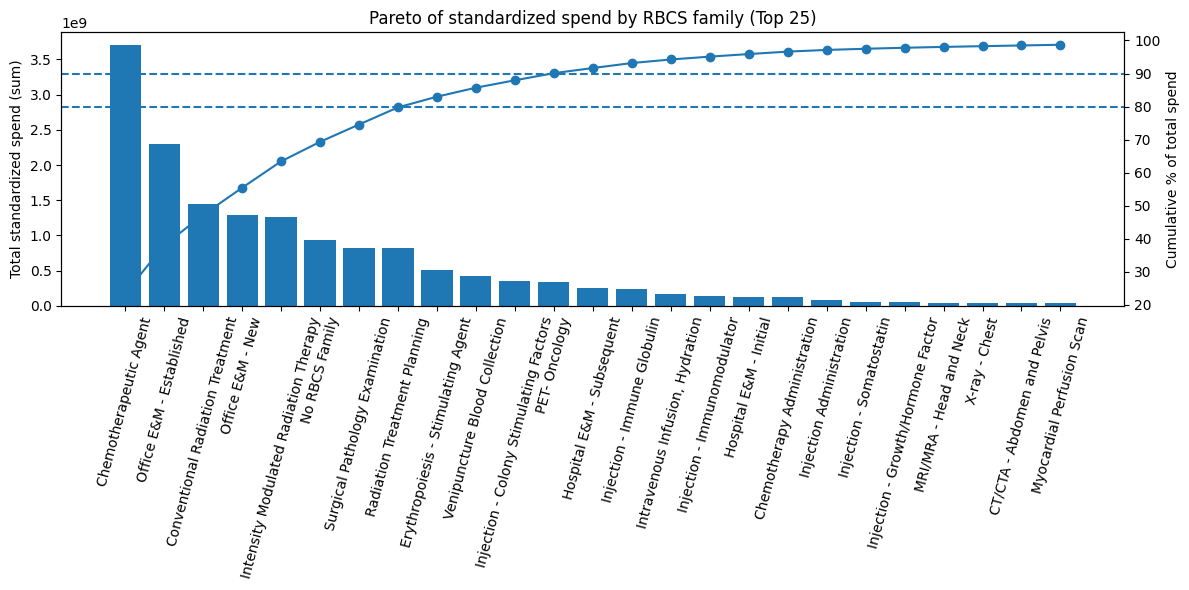

,rbcs_family_desc,sum_stdzd_spend,cum_pct_spend
16,Chemotherapeutic Agent,3.700731e+09,0.234767
82,Office E&M - Established,2.293224e+09,0.380245
24,Conventional Radiation Treatment,1.447973e+09,0.472101
83,Office E&M - New,1.293581e+09,0.554164
64,Intensity Modulated Radiation Therapy,1.260569e+09,0.634132
79,No RBCS Family,9.314582e+08,0.693222
97,Surgical Pathology Examination,8.269309e+08,0.745680
90,Radiation Treatment Planning,8.176813e+08,0.797553
37,Erythropoiesis - Stimulating Agent,5.098666e+08,0.829898
106,Venipuncture Blood Collection,4.297005e+08,0.857157


In [125]:
# 1) Spend by family
fam = (eda_df.groupby("rbcs_family_desc", as_index=False)
       .agg(sum_stdzd_spend=("stdzd_spend", "sum"))
       .sort_values("sum_stdzd_spend", ascending=False))

# 2) Cumulative percent of spend
fam["cum_spend"] = fam["sum_stdzd_spend"].cumsum()
total_spend = fam["sum_stdzd_spend"].sum()
fam["cum_pct_spend"] = fam["cum_spend"] / total_spend

# 3) Pick top N to display
N = 25
top = fam.head(N).copy()

# 4) Plot: bars = spend, line = cumulative percent
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(top["rbcs_family_desc"], top["sum_stdzd_spend"])
ax1.set_ylabel("Total standardized spend (sum)")
ax1.set_title(f"Pareto of standardized spend by RBCS family (Top {N})")
ax1.tick_params(axis="x", rotation=75)

ax2 = ax1.twinx()
ax2.plot(top["rbcs_family_desc"], top["cum_pct_spend"] * 100, marker="o")
ax2.set_ylabel("Cumulative % of total spend")

# Optional reference lines (80/20 rule vibe)
ax2.axhline(80, linestyle="--")
ax2.axhline(90, linestyle="--")

plt.tight_layout()
plt.show()

# Optional: show the key numbers as a table
top[["rbcs_family_desc", "sum_stdzd_spend", "cum_pct_spend"]].head(15)

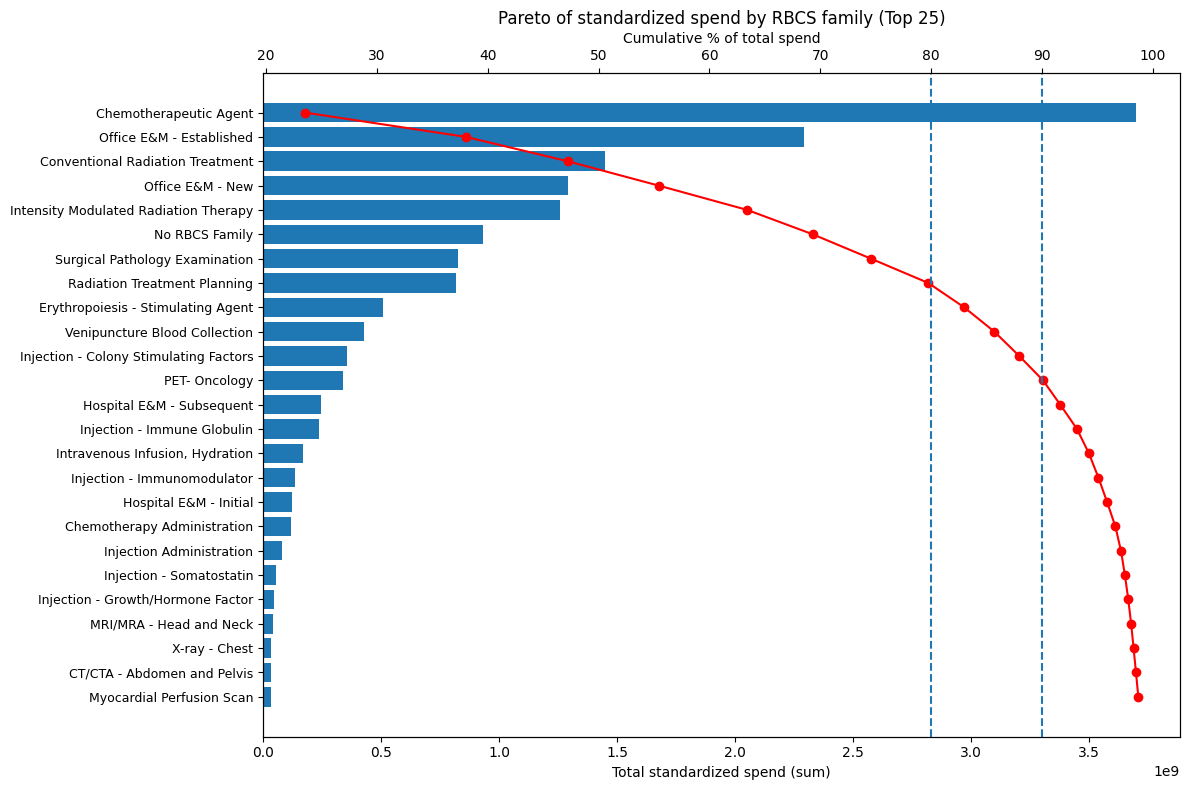

In [126]:
# 1) Spend by family
fam = (eda_df.groupby("rbcs_family_desc", as_index=False)
       .agg(sum_stdzd_spend=("stdzd_spend", "sum"))
       .sort_values("sum_stdzd_spend", ascending=False))

# 2) Cumulative percent of spend
fam["cum_spend"] = fam["sum_stdzd_spend"].cumsum()
total_spend = fam["sum_stdzd_spend"].sum()
fam["cum_pct_spend"] = fam["cum_spend"] / total_spend

# fam must already be sorted desc by sum_stdzd_spend and have cum_pct_spend computed
N = 25
top = fam.head(N).copy()

# Reverse so biggest is at top in barh
top = top.iloc[::-1].reset_index(drop=True)

y = np.arange(len(top))

fig, ax1 = plt.subplots(figsize=(12, 8))

# Bars (spend)
ax1.barh(y, top["sum_stdzd_spend"])
ax1.set_yticks(y)
ax1.set_yticklabels(top["rbcs_family_desc"], fontsize=9)
ax1.set_xlabel("Total standardized spend (sum)")
ax1.set_title(f"Pareto of standardized spend by RBCS family (Top {N})")

# Line (cumulative percent) on a top x-axis or secondary x-axis
ax2 = ax1.twiny()
ax2.plot(top["cum_pct_spend"] * 100, y, marker="o", c = "red")
ax2.set_xlabel("Cumulative % of total spend")

# Reference lines
ax2.axvline(80, linestyle="--")
ax2.axvline(90, linestyle="--")

plt.tight_layout()
plt.show()

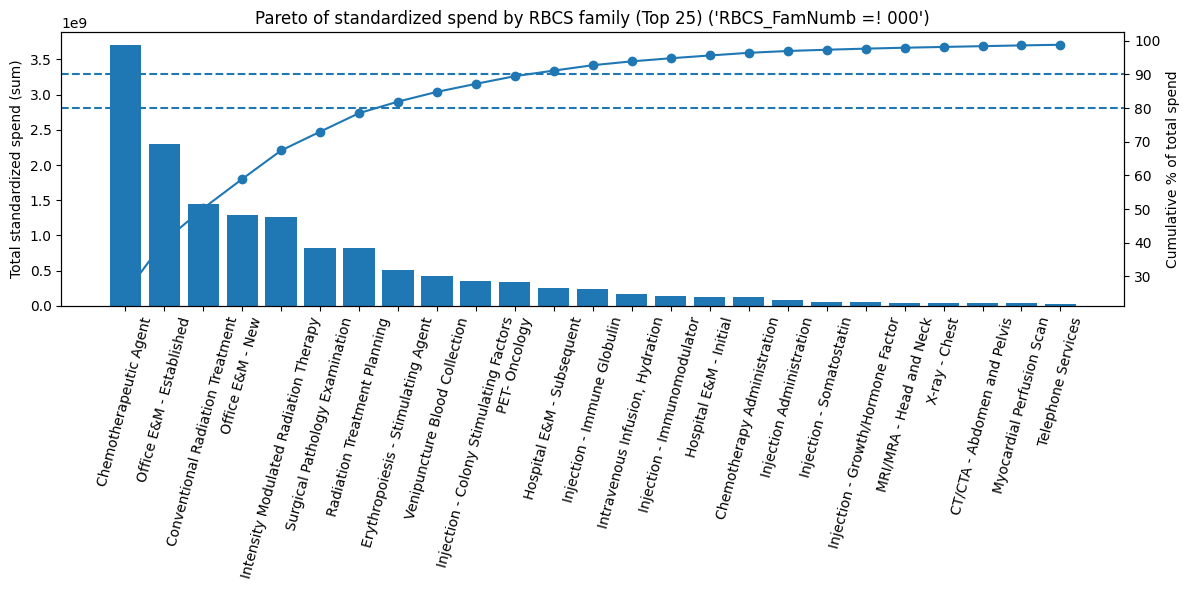

,rbcs_family_desc,sum_stdzd_spend,cum_pct_spend
16,Chemotherapeutic Agent,3.700731e+09,0.249511
81,Office E&M - Established,2.293224e+09,0.404124
24,Conventional Radiation Treatment,1.447973e+09,0.501750
82,Office E&M - New,1.293581e+09,0.588966
64,Intensity Modulated Radiation Therapy,1.260569e+09,0.673956
96,Surgical Pathology Examination,8.269309e+08,0.729709
89,Radiation Treatment Planning,8.176813e+08,0.784839
37,Erythropoiesis - Stimulating Agent,5.098666e+08,0.819215
105,Venipuncture Blood Collection,4.297005e+08,0.848186
54,Injection - Colony Stimulating Factors,3.539776e+08,0.872052


In [127]:
# 1) Spend by family
eda_mapped = eda_df[eda_df["RBCS_FamNumb"] != "000"].copy()

fam = (eda_mapped.groupby("rbcs_family_desc", as_index=False)
       .agg(sum_stdzd_spend=("stdzd_spend", "sum"))
       .sort_values("sum_stdzd_spend", ascending=False))

# 2) Cumulative percent of spend
fam["cum_spend"] = fam["sum_stdzd_spend"].cumsum()
total_spend = fam["sum_stdzd_spend"].sum()
fam["cum_pct_spend"] = fam["cum_spend"] / total_spend

# 3) Pick top N to display
N = 25
top = fam.head(N).copy()

# 4) Plot: bars = spend, line = cumulative percent
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(top["rbcs_family_desc"], top["sum_stdzd_spend"])
ax1.set_ylabel("Total standardized spend (sum)")
ax1.set_title(f"Pareto of standardized spend by RBCS family (Top {N}) ('RBCS_FamNumb =! 000')")
ax1.tick_params(axis="x", rotation=75)

ax2 = ax1.twinx()
ax2.plot(top["rbcs_family_desc"], top["cum_pct_spend"] * 100, marker="o")
ax2.set_ylabel("Cumulative % of total spend")

# Optional reference lines (80/20 rule vibe)
ax2.axhline(80, linestyle="--")
ax2.axhline(90, linestyle="--")

plt.tight_layout()
plt.show()

# Optional: show the key numbers as a table
top[["rbcs_family_desc", "sum_stdzd_spend", "cum_pct_spend"]].head(15)

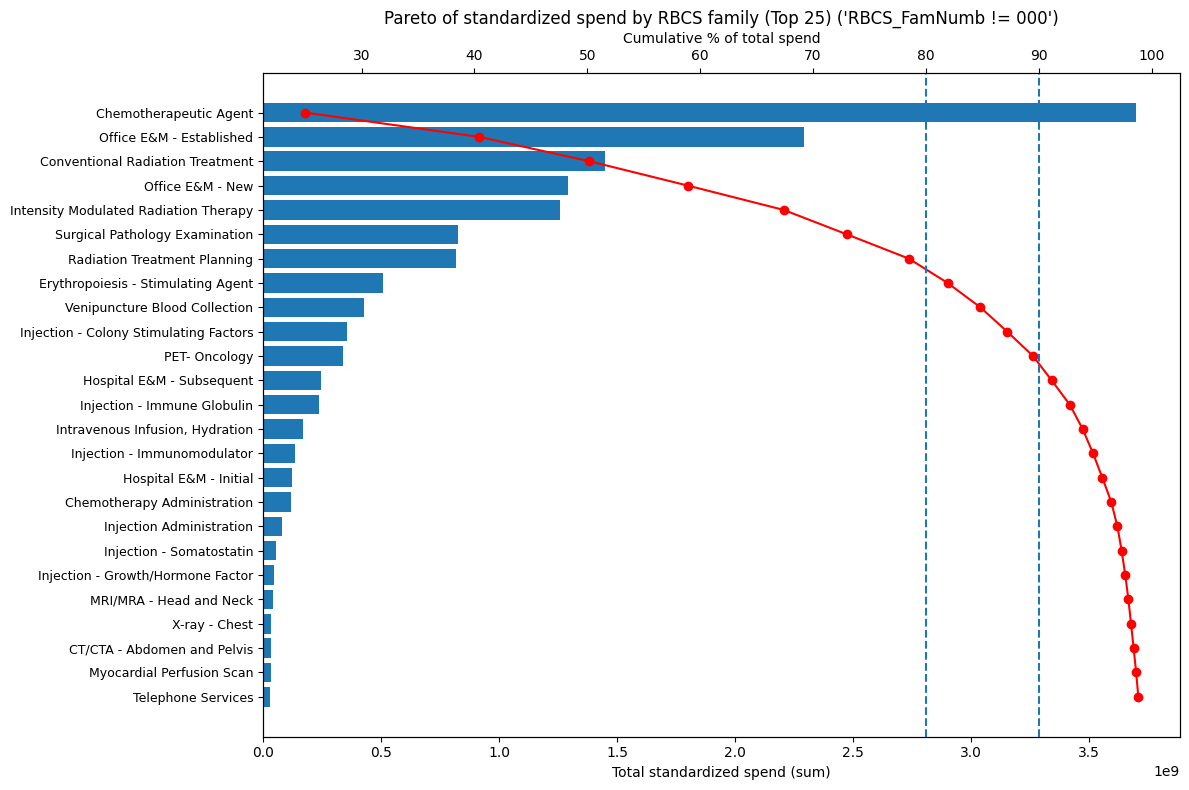

In [128]:
# 1) Spend by family
eda_mapped = eda_df[eda_df["RBCS_FamNumb"] != "000"].copy()

fam = (eda_mapped.groupby("rbcs_family_desc", as_index=False)
       .agg(sum_stdzd_spend=("stdzd_spend", "sum"))
       .sort_values("sum_stdzd_spend", ascending=False))

# 2) Cumulative percent of spend
fam["cum_spend"] = fam["sum_stdzd_spend"].cumsum()
total_spend = fam["sum_stdzd_spend"].sum()
fam["cum_pct_spend"] = fam["cum_spend"] / total_spend

# fam must already be sorted desc by sum_stdzd_spend and have cum_pct_spend computed
N = 25
top = fam.head(N).copy()

# Reverse so biggest is at top in barh
top = top.iloc[::-1].reset_index(drop=True)

y = np.arange(len(top))

fig, ax1 = plt.subplots(figsize=(12, 8))

# Bars (spend)
ax1.barh(y, top["sum_stdzd_spend"])
ax1.set_yticks(y)
ax1.set_yticklabels(top["rbcs_family_desc"], fontsize=9)
ax1.set_xlabel("Total standardized spend (sum)")
ax1.set_title(f"Pareto of standardized spend by RBCS family (Top {N}) ('RBCS_FamNumb != 000')")

# Line (cumulative percent) on a top x-axis or secondary x-axis
ax2 = ax1.twiny()
ax2.plot(top["cum_pct_spend"] * 100, y, marker="o", c = "red")
ax2.set_xlabel("Cumulative % of total spend")

# Reference lines
ax2.axvline(80, linestyle="--")
ax2.axvline(90, linestyle="--")

plt.tight_layout()
plt.show()

You implemented the Pareto correctly, and the outputs are telling a very clear story.

**How to interpret the “Top families by total services” table**

That table is basically answering: **“What kinds of things are being done the most often (by count of services)?”**

- **Services_sum is volume**, not dollars.
- So it is totally possible for something to be huge in services but not huge in spend (cheap but frequent), and vice versa (expensive but not frequent).

**Why “No RBCS Family” is so high in services**

Given what you already proved earlier, **RBCS_FamNumb = ‘000’ is mostly injection-related and drug-indicated** (about ~91% of services have “injection” in the description, and ~98% of services are HCPCS_Drug_Ind = Y). That usually implies:

- These are **drug J-codes and related admin-type codes** that your RBCS mapping is not assigning to a regular family, so they fall into the **“000 / No family” bucket**.
- It is likely a **real “unmapped/other” bucket**, not random noise, but it is also **not clinically interpretable as a real service family** like “Chemo agent” or “Radiation planning”.

So interpret it as: **“A big chunk of volume is in drug injection codes that are not mapped into a specific RBCS family.”**

That is not automatically “bad”. It just means you should treat it intentionally in EDA and modeling (more on that below).

**How to interpret the “Top families by total standardized spend” table**

This table answers: **“Where is the money?”**

- Here, **Chemotherapeutic Agent is #1**, which makes sense because chemo drugs are expensive even if not always the #1 by pure service count.
- **Office E&M** categories being near the top is also common because they combine meaningful volume with non-trivial cost.
- **Radiation families** show up strongly because they are high-cost and systematic.

**Where “No RBCS Family” fits here**

It is **still large** (around 0.93B in your full table, top 6), but it becomes **less dominant than the big clinical families**.

That matches your earlier diagnosis:

- “000” is **massive volume**, but its **median log cost is lower than other families**.
- Still, because volume is huge, it can become **material spend**.

**How to interpret the Pareto tables and plots (the key story)**

A Pareto answers: **“How concentrated is spend in a small number of families?”**

From your table **including** “No RBCS Family”:

- Top 1 family (Chemo agent) already gets you to **~23.5%** of spend.
- Top 5 gets you to **~63.4%**.
- Top 8 gets you to **~79.8%** (you’re basically at the 80% line).
- Top 12 gets you to **~90.1%**.

That is a very strong concentration story: **a small set of service families explains most total standardized spend**.

When you **exclude** RBCS_FamNumb = ‘000’, the curve gets even “cleaner” conceptually:

- Top 5 gets you to **~67.4%**.
- Top 7 gets you to **~78.5%**.
- Top 11 gets you to **~89.5%**.

So “000” is not driving the whole Pareto story. The story holds either way.

**What I would do with “No RBCS Family” going forward**

You have two defensible paths. Pick one and be consistent.

**Option 1 (recommended for clean storytelling)**

**Exclude FamNumb = ‘000’ from the “service mix and spend concentration” plots**, and explicitly label it as “unmapped drug injection codes” elsewhere.

Why:

- Those plots are meant to tell a clinical/operational story about families.
- “No RBCS Family” is not interpretable in the same way.

You can still keep it in the dataset for modeling if you want, but keep the family-level “mix” charts clean.

**Option 2 (keep it, but treat it as its own explicit bucket)**

Keep it in plots, but **rename it in charts** to something like:

- “Unmapped (000) drug injection codes”
    
    so readers do not think it is a meaningful service family.
    

**Quick next EDA steps that fit perfectly after your Pareto**

1. **Make a second Pareto by Place_Of_Srvc** (F vs O).
    
    Question it answers: “Is spend concentration different in facility vs office settings?”
    
2. **Make the Pareto within provider_type** (HemOnc vs RadOnc, etc.).
    
    Question it answers: “Are different specialties driven by different spend families?”
    
3. **Add one table: top 10 families by spend, with median and p95 of log_stdzd_amt_per_service**
    
    Question it answers: “Which families are expensive because of unit cost vs expensive because of volume?”
    

If you want, paste your eda_df column list (or the EDA extract SQL you used), and I’ll give you the exact code blocks for these three so they drop into the notebook cleanly.

In [129]:
eda_df.columns

Index(['Rndrng_NPI', 'Year', 'RBCS_FamNumb', 'Place_Of_Srvc',
       'rbcs_family_desc', 'rbcs_cat', 'rbcs_cat_subcat', 'provider_type',
       'is_core_scope', 'state', 'zip5', 'ruca', 'ruca_bucket', 'services',
       'benes', 'bene_day_services', 'stdzd_amt_per_service',
       'allowed_amt_per_service', 'payment_amt_per_service',
       'submitted_charge_per_service', 'stdzd_spend', 'allowed_spend',
       'payment_spend', 'submitted_spend', 'log_stdzd_amt_per_service',
       'log_services', 'log_benes', 'bene_avg_risk_score',
       'years_since_enumeration', 'pct_cancer6', 'pct_diabetes', 'pct_ckd',
       'pct_copd', 'pct_htn', 'p_cancer6', 'p_diabetes', 'p_ckd', 'p_copd',
       'p_htn', 'tot_benes', 'tot_srvcs', 'tot_mdcr_stdzd_amt',
       'provider_year_stdzd_amt_per_service', 'services_bins',
       'services_custom', 'services_custom2'],
      dtype='object')

In [130]:
eda_df["ruca_bucket"].value_counts()

ruca_bucket
Urban       312005
Suburban     14891
Rural         2487
Unknown        188
Name: count, dtype: int64

## EDA 5. Place-of-service effects within major families

**Plots**

For top 8 families by spend:

1. Box/violin: `stdzd_amt_per_service` by `Place_Of_Srvc`, faceted by `rbcs_family_desc`
2. Stacked bar: share of `services` by `Place_Of_Service` for each `rbcs_family_desc`

**Questions answered**

- How much does site-of-care affect cost per service?
- Is provider variation partly a “site-of-care mix” story?

In [131]:
(eda_df
 .groupby("rbcs_family_desc")
 .agg(total_stdzd_spend = ("stdzd_spend","sum"))
 .reset_index()
 .sort_values("total_stdzd_spend", ascending = False)[:8])

,rbcs_family_desc,total_stdzd_spend
16,Chemotherapeutic Agent,3.700731e+09
82,Office E&M - Established,2.293224e+09
24,Conventional Radiation Treatment,1.447973e+09
83,Office E&M - New,1.293581e+09
64,Intensity Modulated Radiation Therapy,1.260569e+09
79,No RBCS Family,9.314582e+08
97,Surgical Pathology Examination,8.269309e+08
90,Radiation Treatment Planning,8.176813e+08


In [132]:
top_8_rbcs_by_spend = (eda_df
                       .groupby("rbcs_family_desc")
                       .agg(total_stdzd_spend = ("stdzd_spend","sum"))
                       .reset_index()
                       .sort_values("total_stdzd_spend", ascending = False)[:8]["rbcs_family_desc"]
                       .to_list())

In [133]:
top_8_rbcs_by_spend

['Chemotherapeutic Agent',
 'Office E&M - Established',
 'Conventional Radiation Treatment',
 'Office E&M - New',
 'Intensity Modulated Radiation Therapy',
 'No RBCS Family',
 'Surgical Pathology Examination',
 'Radiation Treatment Planning']

In [134]:
eda_top_8 = eda_df.loc[eda_df["rbcs_family_desc"].isin(top_8_rbcs_by_spend),:]

/Users/ozkangelincik/Envs/medicare-provider-benchmarking-engine/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


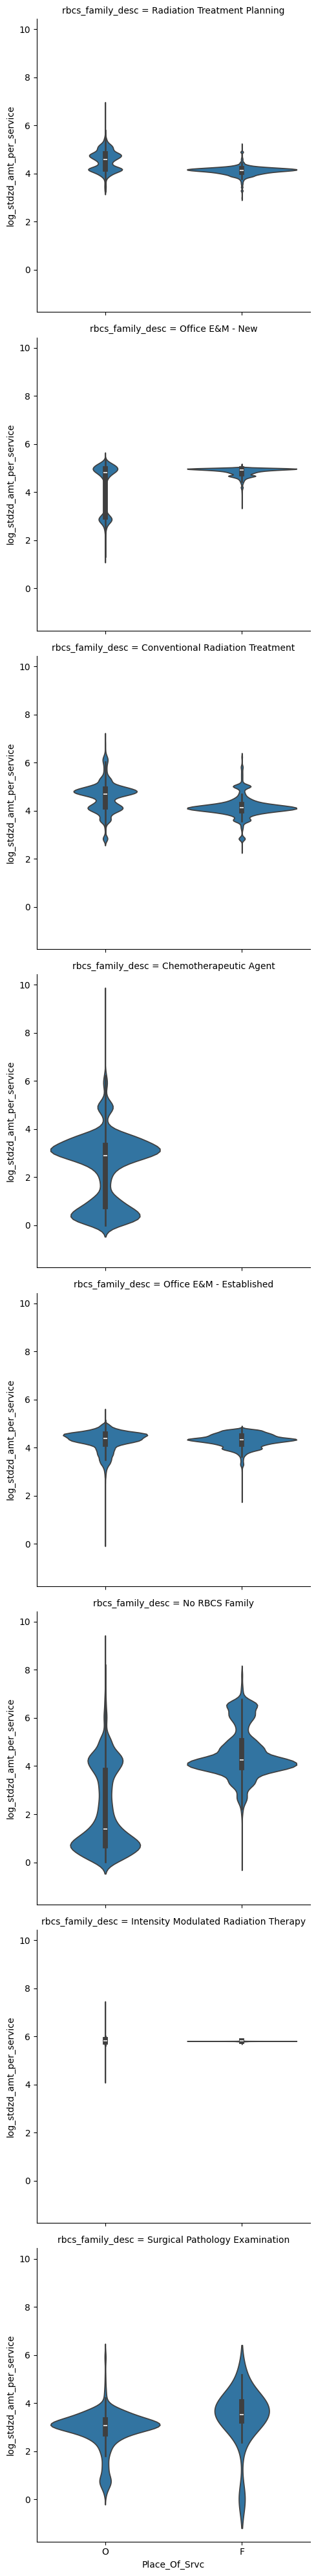

In [135]:
g = sns.FacetGrid(eda_top_8, row="rbcs_family_desc", height = 5, aspect=1)

g.map(sns.violinplot, "Place_Of_Srvc", "log_stdzd_amt_per_service")

plt.show()

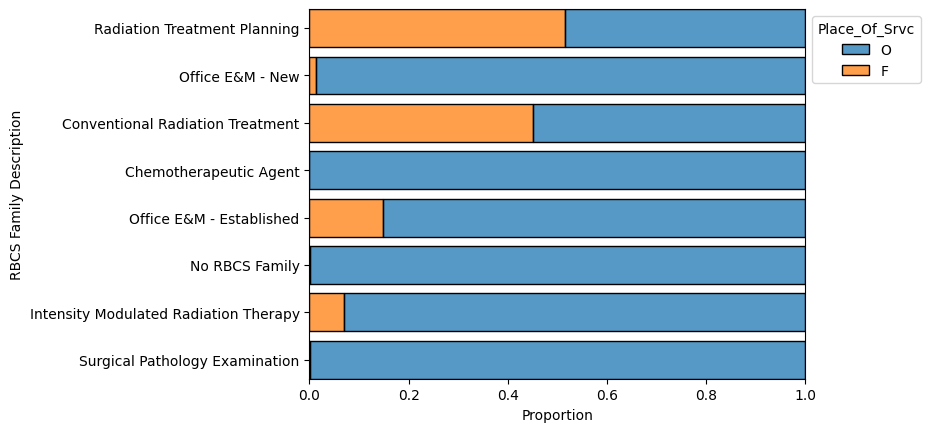

In [136]:
# Assign the plot output to a variable (e.g., 'ax') to capture the axes
ax = sns.histplot(
    data=eda_top_8,
    y="rbcs_family_desc",
    hue="Place_Of_Srvc",
    weights="services",
    multiple="fill",
    shrink=0.8,
)
plt.xlabel("Proportion")
plt.ylabel("RBCS Family Description")

# Move the legend
sns.move_legend(
    ax, 
    "upper left", # Anchor point within the legend box
    bbox_to_anchor=(1, 1), # Coordinates (x, y) relative to the plot area (0,0 bottom-left, 1,1 top-right)
    title="Place_Of_Srvc" # Optional: set the legend title
)

plt.show()

## EDA 6. Specialty comparisons (your 5 oncology types)

**Plots**

- Provider counts: n unique `Rndrng_NPI` by `provider_type` and `Year` (table)
- Distribution: `provider_year_stdzd_amt_per_service` by `provider_type` (box)
- Risk score distribution, `bene_avg_risk_score`, by `provider_typ`e (box)
- `services` distribution by `provider_type` (box)

**Questions answered**

- Are specialties fundamentally different in risk, volume, and cost intensity?
- Does it justify including provider_type as a feature?
- Do we need later stratified evaluation by specialty?

In [137]:
eda_df.columns

Index(['Rndrng_NPI', 'Year', 'RBCS_FamNumb', 'Place_Of_Srvc',
       'rbcs_family_desc', 'rbcs_cat', 'rbcs_cat_subcat', 'provider_type',
       'is_core_scope', 'state', 'zip5', 'ruca', 'ruca_bucket', 'services',
       'benes', 'bene_day_services', 'stdzd_amt_per_service',
       'allowed_amt_per_service', 'payment_amt_per_service',
       'submitted_charge_per_service', 'stdzd_spend', 'allowed_spend',
       'payment_spend', 'submitted_spend', 'log_stdzd_amt_per_service',
       'log_services', 'log_benes', 'bene_avg_risk_score',
       'years_since_enumeration', 'pct_cancer6', 'pct_diabetes', 'pct_ckd',
       'pct_copd', 'pct_htn', 'p_cancer6', 'p_diabetes', 'p_ckd', 'p_copd',
       'p_htn', 'tot_benes', 'tot_srvcs', 'tot_mdcr_stdzd_amt',
       'provider_year_stdzd_amt_per_service', 'services_bins',
       'services_custom', 'services_custom2'],
      dtype='object')

In [140]:
eda_df.groupby(["provider_type", "Year"]).agg(npi_count = ("Rndrng_NPI", "count"))

npi_count
provider_type          Year           
Gynecological Oncology 2021       4019
                       2022       3945
                       2023       3936
Hematology-Oncology    2021      55409
                       2022      54188
                       2023      53319
Medical Oncology       2021      19877
                       2022      19031
                       2023      18847
Radiation Oncology     2021      27719
                       2022      27929
                       2023      27938
Surgical Oncology      2021       4339
                       2022       4400
                       2023       4675

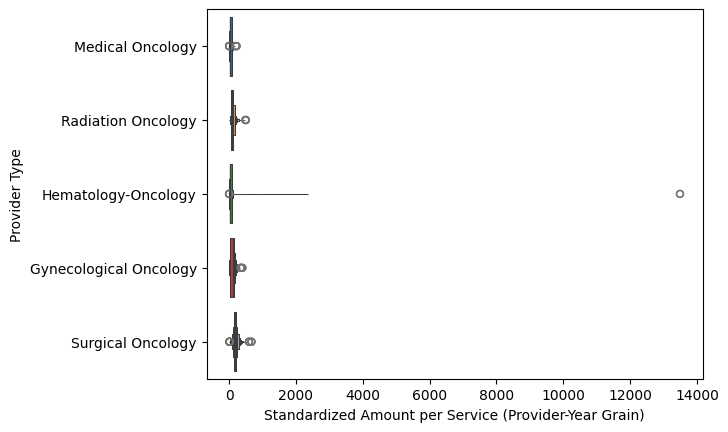

In [151]:
g = sns.boxenplot(
    data=eda_df,
    x="provider_year_stdzd_amt_per_service",
    y="provider_type",
    hue="provider_type"
)

g.set_xlabel("Standardized Amount per Service (Provider-Year Grain)")
g.set_ylabel("Provider Type")


plt.show()

In [158]:
eda_df.loc[eda_df.provider_year_stdzd_amt_per_service>12000,:]

,Rndrng_NPI,Year,RBCS_FamNumb,Place_Of_Srvc,rbcs_family_desc,rbcs_cat,rbcs_cat_subcat,provider_type,is_core_scope,state,zip5,ruca,ruca_bucket,services,benes,bene_day_services,stdzd_amt_per_service,allowed_amt_per_service,payment_amt_per_service,submitted_charge_per_service,stdzd_spend,allowed_spend,payment_spend,submitted_spend,log_stdzd_amt_per_service,log_services,log_benes,bene_avg_risk_score,years_since_enumeration,pct_cancer6,pct_diabetes,pct_ckd,pct_copd,pct_htn,p_cancer6,p_diabetes,p_ckd,p_copd,p_htn,tot_benes,tot_srvcs,tot_mdcr_stdzd_amt,provider_year_stdzd_amt_per_service,services_bins,services_custom,services_custom2
29122,1629222450,2022,005,F,Hospital E&M - Initial,E,EI,Hematology-Oncology,1,WI,53226,1.0,Urban,13.0,13.0,13.0,78.950000,94.046923,75.246923,460.0,1026.35,1222.61,978.21,5980.0,4.381401,2.639057,2.639057,3.0787,14.0,NaN,33.0,44.0,NaN,75.0,NaN,0.33,0.44,NaN,0.75,36,103.0,1389694.2,13492.176699,"(-510.493, 104309.6]",12-25,12-25
208692,1629222450,2022,003,F,Hospital E&M - Subsequent,E,EI,Hematology-Oncology,1,WI,53226,1.0,Urban,22.0,12.0,22.0,81.222727,96.793636,78.199091,474.0,1786.90,2129.46,1720.38,10428.0,4.409432,3.135494,2.564949,3.0787,14.0,NaN,33.0,44.0,NaN,75.0,NaN,0.33,0.44,NaN,0.75,36,103.0,1389694.2,13492.176699,"(-510.493, 104309.6]",12-25,12-25


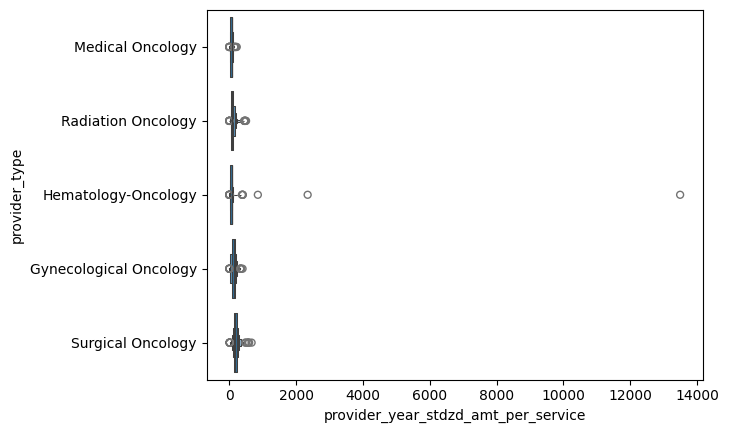

In [159]:
py = (eda_df[["Rndrng_NPI","Year","provider_type","provider_year_stdzd_amt_per_service"]]
      .drop_duplicates(subset=["Rndrng_NPI","Year"]))

sns.boxenplot(
    data=py,
    x="provider_year_stdzd_amt_per_service",
    y="provider_type"
)
plt.show()

In [166]:
py.sort_values("provider_year_stdzd_amt_per_service", ascending=False).head(10)

,Rndrng_NPI,Year,provider_type,provider_year_stdzd_amt_per_service
29122,1629222450,2022,Hematology-Oncology,13492.176699
130994,1356531453,2023,Hematology-Oncology,2347.225098
86790,1356531453,2022,Hematology-Oncology,857.298822
133633,1033174651,2021,Surgical Oncology,670.401061
32988,1780889204,2021,Surgical Oncology,596.410292
203790,1750540233,2021,Surgical Oncology,568.727416
242860,1952508038,2023,Surgical Oncology,567.081696
137397,1033174651,2022,Surgical Oncology,560.150959
162162,1558463653,2021,Radiation Oncology,503.982814
48939,1679540736,2021,Surgical Oncology,503.643125


In [169]:
py.loc[py.provider_year_stdzd_amt_per_service>=13492,:]

,Rndrng_NPI,Year,provider_type,provider_year_stdzd_amt_per_service
29122,1629222450,2022,Hematology-Oncology,13492.176699


In [170]:
con.sql(
    """
SELECT *
FROM provider_year_features
LIMIT 2
"""
)

┌────────────┬───────┬─────────────────────┬───────────────┬─────────┬─────────┬────────┬─────────────────────────────────────────────────────────────────────────────────────┬───────────────┬───────────┬───────────┬────────────────┬──────────────────────┬──────────────────────┬────────────────────┬───────────────────────┬─────────────────────────┬─────────────────────────┬────────────────┬─────────────────────┬───────────────┬────────────────────┬─────────────────────┬──────────────┬─────────────────┬───────────────┬───────────────┬──────────────────┬─────────────┬──────────────┬─────────┬──────────┬─────────┬─────────────────────────┐
│ Rndrng_NPI │ Year  │    provider_type    │ is_core_scope │  state  │  zip5   │  ruca  │                                      ruca_desc                                      │ tot_hcpcs_cds │ tot_benes │ tot_srvcs │ tot_sbmtd_chrg │ tot_mdcr_allowed_amt │ tot_mdcr_payment_amt │ tot_mdcr_stdzd_amt │ stdzd_amt_per_service │ payment_amt_per_service │ allowe

In [184]:
con.sql(
    """
SELECT tot_mdcr_stdzd_amt, tot_srvcs
FROM provider_year_features
WHERE
    Rndrng_NPI=1629222450 AND Year=2022
"""
)

┌────────────────────┬───────────┐
│ tot_mdcr_stdzd_amt │ tot_srvcs │
│       double       │  double   │
├────────────────────┼───────────┤
│          1389694.2 │     103.0 │
└────────────────────┴───────────┘

In [178]:
con.sql(
    """
SELECT *
FROM prov_svc_onco_core_prov_all_rbcs_nppes
WHERE 
    Rndrng_NPI=1629222450 
    AND Year=2022
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬────────────────────────────┬─────────────────────────┬─────────────────┬──────────────────────┬─────────────────────┬──────────────────────┬──────────────────┬───────────────────┬───────────────────────────┬─────────────────────────┬───────────────────┬───────────────────┬─────────────────────────────────────────────────────────────────────────────────────┬────────────────────┬─────────────────────┬───────────────────────────────┬──────────┬─────────────────────────────────────────────────────────────────┬────────────────┬───────────────┬───────────┬───────────┬────────────────────┬────────────────┬────────────────────┬───────────────────┬────────────────────┬───────┬───────────────┬──────────────────────────────┬───────────────────────────┬───────────────────┬────────────────────────┬───────────────────────┬──────────────────────┬────────────────────┬─────────────────────┬─────────────────────────────┬───────────────────────────┬─────────────────────┬───────────────────

In [181]:
con.sql(
    """
SELECT *
FROM eda_dataset
WHERE 
    Rndrng_NPI=1629222450 
    AND Year=2022
"""
)

┌────────────┬───────┬──────────────┬───────────────┬───────────────────────────┬──────────┬─────────────────┬─────────────────────┬───────────────┬─────────┬─────────┬────────┬─────────────┬──────────┬────────┬───────────────────┬───────────────────────┬─────────────────────────┬─────────────────────────┬──────────────────────────────┬────────────────────┬────────────────────┬────────────────────┬─────────────────┬───────────────────────────┬────────────────────┬────────────────────┬─────────────────────┬─────────────────────────┬─────────────┬──────────────┬─────────┬──────────┬─────────┬───────────┬────────────┬────────┬────────┬────────┬───────────┬───────────┬────────────────────┬─────────────────────────────────────┐
│ Rndrng_NPI │ Year  │ RBCS_FamNumb │ Place_Of_Srvc │     rbcs_family_desc      │ rbcs_cat │ rbcs_cat_subcat │    provider_type    │ is_core_scope │  state  │  zip5   │  ruca  │ ruca_bucket │ services │ benes  │ bene_day_services │ stdzd_amt_per_service │ allowed_amt

Let's run this to list every HCPCS row for that provider-year, ordered by volume:

In [182]:
con.sql(
    """
SELECT
  HCPCS_Cd,
  HCPCS_Desc,
  Place_Of_Srvc,
  Tot_Srvcs,
  Avg_Mdcr_Stdzd_Amt,
  (Tot_Srvcs * Avg_Mdcr_Stdzd_Amt) AS stdzd_spend
FROM prov_svc_onco_core_prov_all_rbcs_nppes
WHERE Rndrng_NPI = 1629222450
  AND Year = 2022
ORDER BY Tot_Srvcs DESC;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┬─────────────────────────────────────────────────────────────────┬───────────────┬───────────┬────────────────────┬────────────────────┐
│ HCPCS_Cd │                           HCPCS_Desc                            │ Place_Of_Srvc │ Tot_Srvcs │ Avg_Mdcr_Stdzd_Amt │    stdzd_spend     │
│ varchar  │                             varchar                             │    varchar    │  double   │       double       │       double       │
├──────────┼─────────────────────────────────────────────────────────────────┼───────────────┼───────────┼────────────────────┼────────────────────┤
│ 99233    │ Follow-up hospital inpatient care per day, typically 35 minutes │ F             │      22.0 │       81.222727273 │     1786.900000006 │
│ 99221    │ Initial hospital inpatient care per day, typically 30 minutes   │ F             │      13.0 │              78.95 │ 1026.3500000000001 │
└──────────┴─────────────────────────────────────────────────────────────────┴───────────────┴───────────┴

Then sanity check that these HCPCS rows sum to 103:

In [183]:
con.sql(
    """
SELECT
  SUM(Tot_Srvcs) AS sum_hcpcs_services,
  SUM(Tot_Srvcs * Avg_Mdcr_Stdzd_Amt) AS sum_hcpcs_stdzd_spend
FROM prov_svc_onco_core_prov_all_rbcs_nppes
WHERE Rndrng_NPI = 1629222450
  AND Year = 2022;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────────────────┐
│ sum_hcpcs_services │ sum_hcpcs_stdzd_spend │
│       double       │        double         │
├────────────────────┼───────────────────────┤
│               35.0 │        2813.250000006 │
└────────────────────┴───────────────────────┘

**There seems to be a mismatch here!**

Let's investigate the following idea:

>CMS suppression (most common)
Many HCPCS-level rows are suppressed when beneficiary counts are small (privacy rule). Provider-year totals can still be reported even if many individual HCPCS lines are suppressed. Result: totals look big, visible HCPCS lines look incomplete.

**Check 1**. Compare provider summary counts vs observable HCPCS counts

In [189]:
con.sql(
    """
SELECT
  MAX(Tot_Srvcs_1) AS tot_srvcs_summary,
  COUNT(*) AS n_hcpcs_rows_visible,
  SUM(Tot_Srvcs) AS sum_srvcs_visible
FROM prov_svc_onco_core_prov_all_rbcs_nppes
WHERE Rndrng_NPI=1629222450 AND Year=2022;

"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┬──────────────────────┬───────────────────┐
│ tot_srvcs_summary │ n_hcpcs_rows_visible │ sum_srvcs_visible │
│      double       │        int64         │      double       │
├───────────────────┼──────────────────────┼───────────────────┤
│             103.0 │                    2 │              35.0 │
└───────────────────┴──────────────────────┴───────────────────┘

**Check 2**. Is the table inherently “partial” for many providers

Pick a handful of NPIs and compute:

In [190]:
con.sql(
    """
SELECT
  AVG(sum_srvcs_visible * 1.0 / NULLIF(tot_srvcs_summary,0)) AS avg_visible_share
FROM (
  SELECT
    Rndrng_NPI,
    Year,
    MAX(Tot_Srvcs_1) AS tot_srvcs_summary,
    SUM(Tot_Srvcs) AS sum_srvcs_visible
  FROM prov_svc_onco_core_prov_all_rbcs_nppes
  GROUP BY 1,2
);
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┐
│ avg_visible_share  │
│       double       │
├────────────────────┤
│ 0.7848568484664596 │
└────────────────────┘

Let's investigate the following idea

>The table is filtered to an oncology-core or RBCS-mapped subset
The table includes filtering (“onco_core”, “all_rbcs”). If the provider-year totals are coming from the broader provider summary, but the HCPCS lines are only a subset (oncology-related, mapped, or kept after joins), we will also see gaps.

In [185]:
con.execute(
    """
CREATE OR REPLACE VIEW prov_svc_all_prov_all AS
SELECT
  ps.*,
  p.* EXCLUDE (Rndrng_NPI, Year)
FROM prov_svc_all AS ps
LEFT JOIN prov_all AS p
  ON ps.Rndrng_NPI = p.Rndrng_NPI
 AND ps.Year = p.Year;
""")

In [186]:
con.sql(
    """
SELECT
  SUM(Tot_Srvcs) AS sum_hcpcs_services,
  SUM(Tot_Srvcs * Avg_Mdcr_Stdzd_Amt) AS sum_hcpcs_stdzd_spend
FROM prov_svc_all_prov_all
WHERE Rndrng_NPI = 1629222450
  AND Year = 2022;
"""
)

┌────────────────────┬───────────────────────┐
│ sum_hcpcs_services │ sum_hcpcs_stdzd_spend │
│       double       │        double         │
├────────────────────┼───────────────────────┤
│               35.0 │        2813.250000006 │
└────────────────────┴───────────────────────┘

In [188]:
con.sql(
    """
SELECT *
FROM prov_svc_all_prov_all
WHERE 
    Rndrng_NPI=1629222450 
    AND Year=2022
"""
)

┌────────────┬────────────────────────────┬─────────────────────────┬─────────────────┬──────────────────────┬─────────────────────┬──────────────────────┬──────────────────┬───────────────────┬───────────────────────────┬─────────────────────────┬───────────────────┬───────────────────┬─────────────────────────────────────────────────────────────────────────────────────┬────────────────────┬─────────────────────┬───────────────────────────────┬──────────┬─────────────────────────────────────────────────────────────────┬────────────────┬───────────────┬───────────┬───────────┬────────────────────┬────────────────┬────────────────────┬───────────────────┬────────────────────┬───────┬──────────────────────────────┬───────────────────────────┬───────────────────┬────────────────────────┬───────────────────────┬──────────────────────┬────────────────────┬─────────────────────┬─────────────────────────────┬───────────────────────────┬─────────────────────┬─────────────────────┬─────────────

***Two additional checks that would make this airtight***

**Check A**: Is the missing share correlated with small benes?

Suppression is usually more common when beneficiary counts are small.

If suppression is the driver, avg_visible_share should be lower in the small-benes buckets.

In [209]:
con.sql(
    """
WITH py AS (
  SELECT
    Rndrng_NPI,
    Year,
    MAX(Tot_Benes_1) AS tot_benes_summary,
    MAX(Tot_Srvcs_1) AS tot_srvcs_summary,
    SUM(Tot_Srvcs)   AS sum_srvcs_visible
  FROM prov_svc_all_prov_all
  GROUP BY 1, 2
),
bucketed AS (
  SELECT
    CASE
      WHEN tot_benes_summary < 11 THEN '<11'
      WHEN tot_benes_summary < 50 THEN '11-49'
      WHEN tot_benes_summary < 100 THEN '50-99'
      ELSE '100+'
    END AS benes_bucket,
    sum_srvcs_visible * 1.0 / NULLIF(tot_srvcs_summary, 0) AS visible_share
  FROM py
)
SELECT
  benes_bucket,
  AVG(visible_share) AS avg_visible_share,
  APPROX_QUANTILE(visible_share, 0.10) AS p10,
  APPROX_QUANTILE(visible_share, 0.50) AS p50,
  APPROX_QUANTILE(visible_share, 0.90) AS p90,
  COUNT(*) AS n_provider_years
FROM bucketed
GROUP BY 1
ORDER BY
  CASE benes_bucket
    WHEN '<11' THEN 1
    WHEN '11-49' THEN 2
    WHEN '50-99' THEN 3
    ELSE 4
  END;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬────────────────────┬─────────────────────┬────────────────────┬────────────────────┬──────────────────┐
│ benes_bucket │ avg_visible_share  │         p10         │        p50         │        p90         │ n_provider_years │
│   varchar    │       double       │       double        │       double       │       double       │      int64       │
├──────────────┼────────────────────┼─────────────────────┼────────────────────┼────────────────────┼──────────────────┤
│ 11-49        │   0.72351009631644 │ 0.33013862756862533 │ 0.7953015711914675 │ 0.9957529312733614 │           615624 │
│ 50-99        │ 0.7400718542288993 │ 0.34623554522615374 │  0.810704917707063 │ 0.9923756648708297 │           591979 │
│ 100+         │ 0.8371480113352887 │  0.5540255222768468 │ 0.9137311799068213 │ 0.9888157544414777 │          2240140 │
└──────────────┴────────────────────┴─────────────────────┴────────────────────┴────────────────────┴──────────────────┘

It turns out the hypothesis "Suppression is usually more common when beneficiary counts are small." is false! 

**Check B**: Identify how extreme this provider-year is relative to others

Then check where 35/103 (~0.34) lands in that distribution. My guess is it will be in the “heavily suppressed” tail.

In [208]:
con.sql(

"""
WITH py AS (
  SELECT
    Rndrng_NPI,
    Year,
    MAX(Tot_Srvcs_1) AS tot_srvcs_summary,
    SUM(Tot_Srvcs) AS sum_srvcs_visible
  FROM prov_svc_all_prov_all
  GROUP BY 1,2
),
ratio AS (
  SELECT
    *,
    sum_srvcs_visible * 1.0 / NULLIF(tot_srvcs_summary,0) AS visible_share
  FROM py
)
SELECT
  MIN(visible_share) AS min_share,
  APPROX_QUANTILE(visible_share, 0.05) AS p05,
  APPROX_QUANTILE(visible_share, 0.50) AS p50,
  APPROX_QUANTILE(visible_share, 0.95) AS p95,
  MAX(visible_share) AS max_share
FROM ratio;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────────┬─────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│       min_share       │         p05         │        p50         │        p95         │     max_share      │
│        double         │       double        │       double       │       double       │       double       │
├───────────────────────┼─────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 5.997934593581716e-06 │ 0.29435960247942583 │ 0.8914839184890014 │ 0.9974195311274803 │ 1.0000000000000002 │
└───────────────────────┴─────────────────────┴────────────────────┴────────────────────┴────────────────────┘

Since there is some level of suppression happening (more for the providers with less beneficiaries but more or less consistently across all beneficiary levels), we should check to see how much of this suppression is happening in our `eda_dataset`. 

Let’s now compute the provider-year visible_shares for the rows that actually enter`eda_dataset` after we apply filters (services ≥ 11, RBCS mapped), and see if the distribution changes. 

1) Provider-year visible share for the provider-years that enter eda_dataset

That produces one row per provider-year that actually makes it into `eda_dataset`, with `visible_share_eda`.

In [210]:
con.sql(
    """
WITH py_eda AS (
  SELECT
    Rndrng_NPI,
    Year,
    SUM(services) AS sum_srvcs_in_eda,
    COUNT(*)      AS n_eda_rows
  FROM eda_dataset
  GROUP BY 1,2
),
py_totals AS (
  SELECT
    Rndrng_NPI,
    Year,
    tot_srvcs AS tot_srvcs_summary,
    tot_benes AS tot_benes_summary
  FROM provider_year_features
)
SELECT
  e.Rndrng_NPI,
  e.Year,
  e.sum_srvcs_in_eda,
  t.tot_srvcs_summary,
  e.sum_srvcs_in_eda * 1.0 / NULLIF(t.tot_srvcs_summary, 0) AS visible_share_eda,
  e.n_eda_rows,
  t.tot_benes_summary
FROM py_eda e
JOIN py_totals t
  ON e.Rndrng_NPI = t.Rndrng_NPI
 AND e.Year = t.Year;
"""
)

┌────────────┬───────┬──────────────────┬───────────────────┬─────────────────────┬────────────┬───────────────────┐
│ Rndrng_NPI │ Year  │ sum_srvcs_in_eda │ tot_srvcs_summary │  visible_share_eda  │ n_eda_rows │ tot_benes_summary │
│   int64    │ int32 │      double      │      double       │       double        │   int64    │       int64       │
├────────────┼───────┼──────────────────┼───────────────────┼─────────────────────┼────────────┼───────────────────┤
│ 1649217969 │  2021 │            538.0 │             563.0 │   0.955595026642984 │          5 │               166 │
│ 1710915269 │  2021 │          35750.0 │           98511.0 │ 0.36290363512704166 │         11 │               495 │
│ 1710918032 │  2021 │            391.0 │            7642.0 │ 0.05116461659251505 │          2 │               139 │
│ 1710938519 │  2021 │            459.0 │             545.0 │  0.8422018348623853 │          5 │                85 │
│ 1740418318 │  2021 │             71.0 │              75.0 │  0

2) Summarize the distribution and compare to your earlier “HCPCS visible share” baseline

A) Distribution for the eda_dataset provider-years

In [211]:
con.sql(
    """
WITH py_eda AS (
  SELECT
    Rndrng_NPI,
    Year,
    SUM(services) AS sum_srvcs_in_eda
  FROM eda_dataset
  GROUP BY 1,2
),
joined AS (
  SELECT
    e.Rndrng_NPI,
    e.Year,
    e.sum_srvcs_in_eda,
    p.tot_srvcs AS tot_srvcs_summary,
    e.sum_srvcs_in_eda * 1.0 / NULLIF(p.tot_srvcs, 0) AS visible_share_eda
  FROM py_eda e
  JOIN provider_year_features p
    ON e.Rndrng_NPI = p.Rndrng_NPI
   AND e.Year = p.Year
)
SELECT
  COUNT(*) AS n_provider_years,
  AVG(visible_share_eda) AS avg_share,
  APPROX_QUANTILE(visible_share_eda, 0.05) AS p05,
  APPROX_QUANTILE(visible_share_eda, 0.10) AS p10,
  APPROX_QUANTILE(visible_share_eda, 0.50) AS p50,
  APPROX_QUANTILE(visible_share_eda, 0.90) AS p90,
  APPROX_QUANTILE(visible_share_eda, 0.95) AS p95
FROM joined;
"""
)

┌──────────────────┬────────────────────┬─────────────────────┬────────────────────┬───────────────────┬────────────────────┬────────────────────┐
│ n_provider_years │     avg_share      │         p05         │        p10         │        p50        │        p90         │        p95         │
│      int64       │       double       │       double        │       double       │      double       │       double       │       double       │
├──────────────────┼────────────────────┼─────────────────────┼────────────────────┼───────────────────┼────────────────────┼────────────────────┤
│            56804 │ 0.7848568484664621 │ 0.15072354928277115 │ 0.3469249305046515 │ 0.891321912642467 │ 0.9922532452894719 │ 1.0294069818810136 │
└──────────────────┴────────────────────┴─────────────────────┴────────────────────┴───────────────────┴────────────────────┴────────────────────┘

B) Side-by-side comparison: “HCPCS visible share” vs “EDA share”, but on the same provider-years

This lets you see how much extra drop is coming from **your filters**, beyond CMS suppression.

In [212]:
con.sql(
    """
WITH eda_py AS (
  SELECT
    Rndrng_NPI,
    Year,
    SUM(services) AS sum_srvcs_in_eda
  FROM eda_dataset
  GROUP BY 1,2
),
hcpcs_py AS (
  SELECT
    Rndrng_NPI,
    Year,
    MAX(Tot_Srvcs_1) AS tot_srvcs_summary,
    SUM(Tot_Srvcs)   AS sum_srvcs_visible_hcpcs
  FROM prov_svc_all_prov_all
  GROUP BY 1,2
),
joined AS (
  SELECT
    e.Rndrng_NPI,
    e.Year,
    h.tot_srvcs_summary,
    h.sum_srvcs_visible_hcpcs,
    e.sum_srvcs_in_eda,
    h.sum_srvcs_visible_hcpcs * 1.0 / NULLIF(h.tot_srvcs_summary, 0) AS visible_share_hcpcs,
    e.sum_srvcs_in_eda        * 1.0 / NULLIF(h.tot_srvcs_summary, 0) AS visible_share_eda
  FROM eda_py e
  JOIN hcpcs_py h
    ON e.Rndrng_NPI = h.Rndrng_NPI
   AND e.Year = h.Year
)
SELECT
  COUNT(*) AS n_provider_years,
  AVG(visible_share_hcpcs) AS avg_hcpcs_share,
  AVG(visible_share_eda)   AS avg_eda_share,
  APPROX_QUANTILE(visible_share_hcpcs, 0.50) AS p50_hcpcs,
  APPROX_QUANTILE(visible_share_eda,   0.50) AS p50_eda,
  APPROX_QUANTILE(visible_share_hcpcs, 0.90) AS p90_hcpcs,
  APPROX_QUANTILE(visible_share_eda,   0.90) AS p90_eda
FROM joined;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬───────────────────┐
│ n_provider_years │  avg_hcpcs_share   │   avg_eda_share    │     p50_hcpcs      │      p50_eda       │     p90_hcpcs      │      p90_eda      │
│      int64       │       double       │       double       │       double       │       double       │       double       │      double       │
├──────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼───────────────────┤
│            56804 │ 0.7448992599986672 │ 0.7848568484664594 │ 0.8661269923417371 │ 0.8913313067080111 │ 0.9782455031214484 │ 0.992173297754933 │
└──────────────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

1) The `eda_dataset` provider-years have a “pretty complete” picture, on average

From the `visible_share_eda` summary:

- **n = 56,804 provider-years**
- **avg_share = 0.7849**
- **median (p50) = 0.8913**
- **p90 = 0.9923**

Interpretation:

- For the provider-years that make it into `eda_dataset`, we typically observe **most** of their annual services. Median provider-year has about **89%** of services represented.
- But there is still a left tail. **p10 = 0.3469** means 10% of provider-years only have ~35% or less of their annual services represented in `eda_dataset`. So suppression (and/or the service-line inclusion rules) still causes partial visibility for some provider-years.

2) The side-by-side comparison shows us filters are not making visibility worse . If anything, they select “cleaner” provider-years

You got:

- **`avg_hcpcs_share` = 0.7449**
- **`avg_eda_share` = 0.7849**
- **`p50_hcpcs` = 0.8661**
- **`p50_eda` = 0.8913**
- **`p90_hcpcs` = 0.9782**
- **`p90_eda` = 0.9922**

Interpretation:

- If our `eda_dataset` filtering were removing a lot of services beyond CMS suppression, we'd expect **`avg_eda_share` < `avg_hcpcs_share`**.
- We see the opposite. `eda_share` is higher. That means the provider-years that survive into `eda_dataset` tend to be the ones where a larger portion of total services are observable at the service-line level.

**The two nuances not to be missed**

**Nuance A: We are conditioning on “provider-years that enter `eda_dataset`”**

This is selection. We are not saying suppression is gone overall. We are saying:

- “Among provider-years that pass RBCS mapping and services≥11 at the service-line grain, the visible share looks fine.”

That’s good, but it also implies our modeling dataset is biased toward provider-years with:

- higher volumes
- more non-suppressed lines
- more mappable services

That might be acceptable. You just want to be aware of it.

**Nuance B: Your `p95 = 1.0294` is a red flag (shares should not exceed 1)**

A share above 1 can happen because:

- totals and service-line counts are not strictly comparable (different definitions of “services”), or
- duplication/leakage in joins somewhere, or
- rounding plus approximate quantiles, but 1.03 is too high for just rounding.

This does not invalidate the general pattern, but you should sanity check it.

Let's run these two checks:

**Check 1**: how many provider-years have share > 1?

In [213]:
con.sql(
    """
WITH py_eda AS (
  SELECT Rndrng_NPI, Year, SUM(services) AS sum_srvcs_in_eda
  FROM eda_dataset
  GROUP BY 1,2
),
joined AS (
  SELECT
    e.Rndrng_NPI,
    e.Year,
    e.sum_srvcs_in_eda,
    p.tot_srvcs AS tot_srvcs_summary,
    e.sum_srvcs_in_eda * 1.0 / NULLIF(p.tot_srvcs, 0) AS share
  FROM py_eda e
  JOIN provider_year_features p
    ON e.Rndrng_NPI=p.Rndrng_NPI AND e.Year=p.Year
)
SELECT
  SUM(CASE WHEN share > 1 THEN 1 ELSE 0 END) AS n_gt_1,
  MAX(share) AS max_share
FROM joined;
"""
)

┌────────┬───────────┐
│ n_gt_1 │ max_share │
│ int128 │  double   │
├────────┼───────────┤
│   4198 │       2.0 │
└────────┴───────────┘

**Check 2**: inspect the worst offenders

In [214]:
con.sql(
    """
WITH py_eda AS (
  SELECT Rndrng_NPI, Year, SUM(services) AS sum_srvcs_in_eda
  FROM eda_dataset
  GROUP BY 1,2
),
joined AS (
  SELECT
    e.Rndrng_NPI,
    e.Year,
    e.sum_srvcs_in_eda,
    p.tot_srvcs AS tot_srvcs_summary,
    e.sum_srvcs_in_eda * 1.0 / NULLIF(p.tot_srvcs, 0) AS share
  FROM py_eda e
  JOIN provider_year_features p
    ON e.Rndrng_NPI=p.Rndrng_NPI AND e.Year=p.Year
)
SELECT *
FROM joined
WHERE share > 1
ORDER BY share DESC
LIMIT 20;
"""
)

┌────────────┬───────┬──────────────────┬───────────────────┬────────────────────┐
│ Rndrng_NPI │ Year  │ sum_srvcs_in_eda │ tot_srvcs_summary │       share        │
│   int64    │ int32 │      double      │      double       │       double       │
├────────────┼───────┼──────────────────┼───────────────────┼────────────────────┤
│ 1912087271 │  2021 │             76.0 │              38.0 │                2.0 │
│ 1912087271 │  2023 │             78.0 │              39.0 │                2.0 │
│ 1982781373 │  2023 │         429048.0 │          215772.0 │  1.988432234024804 │
│ 1982781373 │  2022 │         219687.0 │          111080.0 │ 1.9777367662945624 │
│ 1184829764 │  2021 │          30414.0 │           15493.0 │ 1.9630801006906344 │
│ 1184829764 │  2022 │         102752.0 │           52346.0 │ 1.9629389065067053 │
│ 1578640793 │  2021 │         529324.0 │          269840.0 │ 1.9616217017491846 │
│ 1184829764 │  2023 │          81592.0 │           42019.0 │ 1.9417882386539422 │
│ 13

The three key facts:

1. **share > 1 happens a lot**
- 4,198 out of 56,804 provider-years (about **7.4%**) have `sum_srvcs_in_eda` > `tot_srvcs_summary`.
2. **The maximum is exactly 2.0** (and several near 2)
- That pattern (exactly 2x or almost 2x) is a classic signature of **systematic duplication** of service-line rows before you aggregated into `eda_dataset`.
3. **`tot_srvcs_summary` comes from provider summary totals**, while `sum_srvcs_in_eda` comes from summing service-line rows.
- Provider totals are not “double-counted” by joins because you used `MAX(Tot_Srvcs_1)` in the provider-year table.
- Service-line sums can be inflated if the underlying service-line table has duplicate rows for the same “real” HCPCS line.

In [215]:
con.sql(
    """
SELECT
  HCPCS_Cd,
  Place_Of_Srvc,
  COUNT(*) AS n_rows,
  SUM(Tot_Srvcs) AS sum_srvcs_across_rows,
  MAX(Tot_Srvcs) AS max_srvcs_single_row
FROM prov_svc_all_prov_all
WHERE Rndrng_NPI = 1912087271 AND Year = 2021
GROUP BY 1,2
HAVING COUNT(*) > 1
ORDER BY n_rows DESC, sum_srvcs_across_rows DESC
LIMIT 50;
"""
)

┌──────────┬───────────────┬────────┬───────────────────────┬──────────────────────┐
│ HCPCS_Cd │ Place_Of_Srvc │ n_rows │ sum_srvcs_across_rows │ max_srvcs_single_row │
│ varchar  │    varchar    │ int64  │        double         │        double        │
├──────────┴───────────────┴────────┴───────────────────────┴──────────────────────┤
│                                      0 rows                                      │
└──────────────────────────────────────────────────────────────────────────────────┘

**Quick sanity check:**

You can verify that the problem is “duplication” and not something conceptual by comparing totals:

**Compare provider-year totals vs your EDA service sums**

If `max_diff` is very large (it likely will be for the big offenders), that reinforces this is not rounding. It is duplicated volume.

In [216]:
con.sql(
    """
WITH eda_py AS (
  SELECT Rndrng_NPI, Year, SUM(services) AS sum_srvcs_in_eda
  FROM eda_dataset
  GROUP BY 1,2
)
SELECT
  COUNT(*) AS n,
  AVG(sum_srvcs_in_eda - p.tot_srvcs) AS avg_diff,
  MAX(sum_srvcs_in_eda - p.tot_srvcs) AS max_diff
FROM eda_py e
JOIN provider_year_features p
  ON e.Rndrng_NPI=p.Rndrng_NPI AND e.Year=p.Year
WHERE sum_srvcs_in_eda > p.tot_srvcs;
"""
)

┌───────┬───────────────────┬──────────┐
│   n   │     avg_diff      │ max_diff │
│ int64 │      double       │  double  │
├───────┼───────────────────┼──────────┤
│  4198 │ 7659.850690805145 │ 268905.0 │
└───────┴───────────────────┴──────────┘

Given what we just observed, the highest-probability source of duplication is our RBCS join (and much less likely the NPPES join). We should interrogate `prov_svc_onco_core_prov_all_rbcs` first, because that is exactly where a one-to-many mapping can silently replicate service-line rows.

Why the RBCS join is suspicious in our exact code 

```
LEFT JOIN rbcs AS r
  ON p.HCPCS_Cd = r.HCPCS_Cd
```

implicitly assumes **`rbcs.HCPCS_Cd` is unique** (one row per HCPCS code). If it is not unique, then one provider-service HCPCS row becomes 2+ rows after the join. That inflates:

- `SUM(Tot_Srvcs)` when we later aggregate
- `SUM(Avg_Mdcr_Stdzd_Amt * Tot_Srvcs)` (spend numerator)
- and therefore can distort service-line rollups and our later `SUM(services)` in `eda_dataset`

Our earlier “no duplicates” check was done on `prov_svc_all_prov_all`, which is pre-RBCS, so it is totally consistent to see no duplication there but still see duplication later.

**Step 1. Let's prove whether RBCS has duplicates per HCPCS code**

Let's run this first. It tells us whether our join can replicate rows.

In [217]:
con.sql(
    """
SELECT
  COUNT(*) AS rbcs_rows,
  COUNT(DISTINCT HCPCS_Cd) AS distinct_hcpcs,
  COUNT(*) - COUNT(DISTINCT HCPCS_Cd) AS extra_rows_due_to_duplicates
FROM rbcs;
"""
)

┌───────────┬────────────────┬──────────────────────────────┐
│ rbcs_rows │ distinct_hcpcs │ extra_rows_due_to_duplicates │
│   int64   │     int64      │            int64             │
├───────────┼────────────────┼──────────────────────────────┤
│     18882 │          16618 │                         2264 │
└───────────┴────────────────┴──────────────────────────────┘

Then let's identify the worst duplicate HCPCS codes:

If this returns anything, our join is one-to-many for those codes.

In [218]:
con.sql(
    """
SELECT
  HCPCS_Cd,
  COUNT(*) AS n_rbcs_rows
FROM rbcs
GROUP BY 1
HAVING COUNT(*) > 1
ORDER BY n_rbcs_rows DESC
LIMIT 50;
"""
)

┌──────────┬─────────────┐
│ HCPCS_Cd │ n_rbcs_rows │
│ varchar  │    int64    │
├──────────┼─────────────┤
│ Q0180    │           4 │
│ 81433    │           3 │
│ 81435    │           3 │
│ 94726    │           3 │
│ 42299    │           3 │
│ 0253T    │           3 │
│ 81507    │           3 │
│ G9980    │           3 │
│ 51798    │           3 │
│ G0507    │           3 │
│   ·      │           · │
│   ·      │           · │
│   ·      │           · │
│ L1025    │           3 │
│ 42815    │           3 │
│ 94727    │           3 │
│ E2100    │           3 │
│ A9590    │           3 │
│ A9530    │           3 │
│ 94618    │           3 │
│ 81442    │           3 │
│ G2024    │           3 │
│ 81432    │           3 │
├──────────┴─────────────┤
│ 50 rows      2 columns │
│ (20 shown)             │
└────────────────────────┘

**Step 2. Measure row multiplication directly: before vs after RBCS join**

This is the most direct “did the join duplicate rows” check.

Pick the same offender provider-year you flagged (or any). For example: Rndrng_NPI=1912087271, Year=2021.

2A) Row counts

If `post_rbcs` has higher row count and higher `SUM(Tot_Srvcs)`, you have confirmed duplication is introduced by RBCS join.

In [219]:
con.sql(
    """
SELECT
  'pre_rbcs' AS stage,
  COUNT(*) AS n_rows
FROM prov_svc_onco_core_prov_all
WHERE Rndrng_NPI=1912087271 AND Year=2021

UNION ALL

SELECT
  'post_rbcs' AS stage,
  COUNT(*) AS n_rows
FROM prov_svc_onco_core_prov_all_rbcs
WHERE Rndrng_NPI=1912087271 AND Year=2021;
"""
)

┌───────────┬────────┐
│   stage   │ n_rows │
│  varchar  │ int64  │
├───────────┼────────┤
│ pre_rbcs  │      1 │
│ post_rbcs │      2 │
└───────────┴────────┘

2B) Service totals

In [220]:
con.sql(
    """
SELECT
  'pre_rbcs' AS stage,
  SUM(Tot_Srvcs) AS sum_tot_srvcs
FROM prov_svc_onco_core_prov_all
WHERE Rndrng_NPI=1912087271 AND Year=2021

UNION ALL

SELECT
  'post_rbcs' AS stage,
  SUM(Tot_Srvcs) AS sum_tot_srvcs
FROM prov_svc_onco_core_prov_all_rbcs
WHERE Rndrng_NPI=1912087271 AND Year=2021;
"""
)

┌───────────┬───────────────┐
│   stage   │ sum_tot_srvcs │
│  varchar  │    double     │
├───────────┼───────────────┤
│ pre_rbcs  │          38.0 │
│ post_rbcs │          76.0 │
└───────────┴───────────────┘

**Step 3. Identify the exact lines getting duplicated after the RBCS join**

Let's do this by comparing the “natural key” of a provider-service line *before* RBCS, then checking how many RBCS matches it gets.

A good key for our provider-service HCPCS data is usually:

(Rndrng_NPI, Year, HCPCS_Cd, Place_Of_Srvc)

(If we want to be extra safe, we can include `HCPCS_Drug_Ind` too.)

In [221]:
con.sql(
    """
SELECT
  p.HCPCS_Cd,
  p.Place_Of_Srvc,
  COUNT(*) AS n_post_join_rows,
  SUM(p.Tot_Srvcs) AS sum_srvcs_post_join,
  MAX(p.Tot_Srvcs) AS max_srvcs_single
FROM prov_svc_onco_core_prov_all_rbcs AS p
WHERE p.Rndrng_NPI=1912087271 AND p.Year=2021
GROUP BY 1,2
HAVING COUNT(*) > 1
ORDER BY n_post_join_rows DESC, sum_srvcs_post_join DESC
LIMIT 50;
"""
)

┌──────────┬───────────────┬──────────────────┬─────────────────────┬──────────────────┐
│ HCPCS_Cd │ Place_Of_Srvc │ n_post_join_rows │ sum_srvcs_post_join │ max_srvcs_single │
│ varchar  │    varchar    │      int64       │       double        │      double      │
├──────────┼───────────────┼──────────────────┼─────────────────────┼──────────────────┤
│ 80502    │ F             │                2 │                76.0 │             38.0 │
└──────────┴───────────────┴──────────────────┴─────────────────────┴──────────────────┘

If we get results here but not in `prov_svc_all_prov_all`, it is basically a smoking gun.

Then let's inspect one duplicated HCPCS code and see what differs across the duplicated rows (RBCS columns):

In [222]:
con.sql(
    """
SELECT
  Rndrng_NPI, Year, HCPCS_Cd, Place_Of_Srvc, Tot_Srvcs,
  RBCS_FamNumb,
  RBCS_Id,
  RBCS_Latest_Assignment,
  RBCS_Analysis_Start_Dt,
  RBCS_Analysis_End_Dt,
  Alt_Assignment_Method,
  RBCS_Id_Ever_Reassigned
FROM prov_svc_onco_core_prov_all_rbcs
WHERE Rndrng_NPI=1912087271 AND Year=2021
  AND HCPCS_Cd = '<PUT_ONE_DUPLICATED_CODE_HERE>'
ORDER BY RBCS_Latest_Assignment DESC, RBCS_Analysis_Start_Dt DESC;
"""
)

┌────────────┬───────┬──────────┬───────────────┬───────────┬──────────────┬─────────┬────────────────────────┬────────────────────────┬──────────────────────┬───────────────────────┬─────────────────────────┐
│ Rndrng_NPI │ Year  │ HCPCS_Cd │ Place_Of_Srvc │ Tot_Srvcs │ RBCS_FamNumb │ RBCS_Id │ RBCS_Latest_Assignment │ RBCS_Analysis_Start_Dt │ RBCS_Analysis_End_Dt │ Alt_Assignment_Method │ RBCS_Id_Ever_Reassigned │
│   int64    │ int32 │ varchar  │    varchar    │  double   │   varchar    │ varchar │         int64          │          date          │         date         │         int64         │          int64          │
├────────────┴───────┴──────────┴───────────────┴───────────┴──────────────┴─────────┴────────────────────────┴────────────────────────┴──────────────────────┴───────────────────────┴─────────────────────────┤
│                                                                                                    0 rows                                                     